# **CMI: Behavior Detection Model 1D-CNN 🌌🧠** 

This is my full solution for the Child Mind Institute "Detect Behavior with Sensor Data" Kaggle competition, [which is linked here](https://www.kaggle.com/competitions/cmi-detect-behavior-with-sensor-data)

***

**✎  Overview:**

Have you ever wondered what makes someone tick? How about, what *is* a tick? This interesting problem from the Child Mind Institute asks us to investigate Body-Focused Repetitive Behaviors (BFRBs) such as nail-biting, hair-pulling and skin-picking, in an effort to better understand how they relate to Obsessive Compulsive Disorder (OCD). 

In a month-long research study conducted by the institute, 81 subjects (children and adults) were given a wrist device (developed by CMI, called "Helios") to wear for an extended period of time. While wearing the device, they were instructed to perform 18 different gestures from 1-4 sitting positions including sitting, sitting while leaning forward with their non-dominant arm resting on their leg, lying on their back, and lying on their side. [Gesture example video](https://youtu.be/WJVFUSJm4As?si=2XfSJGNk4j3Lja4D)

**✎  Data and Task:**

Among these gestures, there were 8 gestures classified as "BRFB-like", and 10 gestures classified as "non-BFRB-like", where BFRB-like gestures being linked to OCD.

In this competition, the Child Mind Institute has tasked the Kaggleverse with building a predictive machine learning model that correctly classifies sequences as one of these 18 gestures. The data is made up of over 1,000 sequences, recorded using the Helios device, with 15-700 observations each being recorded at 10 Hz.

The Helios device recorded 3D acceleration data (in x/y/z directions), orientation data (with w/x/y/z quaternions), temperature (through 5 different sensors), as well as 5 sets of "time-of-flight" data. The acceleration and orientation components are a cateogry of feature commonly referred to as Inertial Measurement Units (IMU), and I will refer to them this way throughout this notebook. If you'd like to read more about the specific sensors used in this study, you can do so below.

- [Accelerometer](https://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/Competitions/Helios2025/IMU_Sensor.pdf)
- [Temperature](https://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/Competitions/Helios2025/Thermopile_Sensor.pdf)
- [Time-of-Flight](https://fcon_1000.projects.nitrc.org/indi/cmi_healthy_brain_network/Competitions/Helios2025/Time_of_Flight_Sensor.pdf)

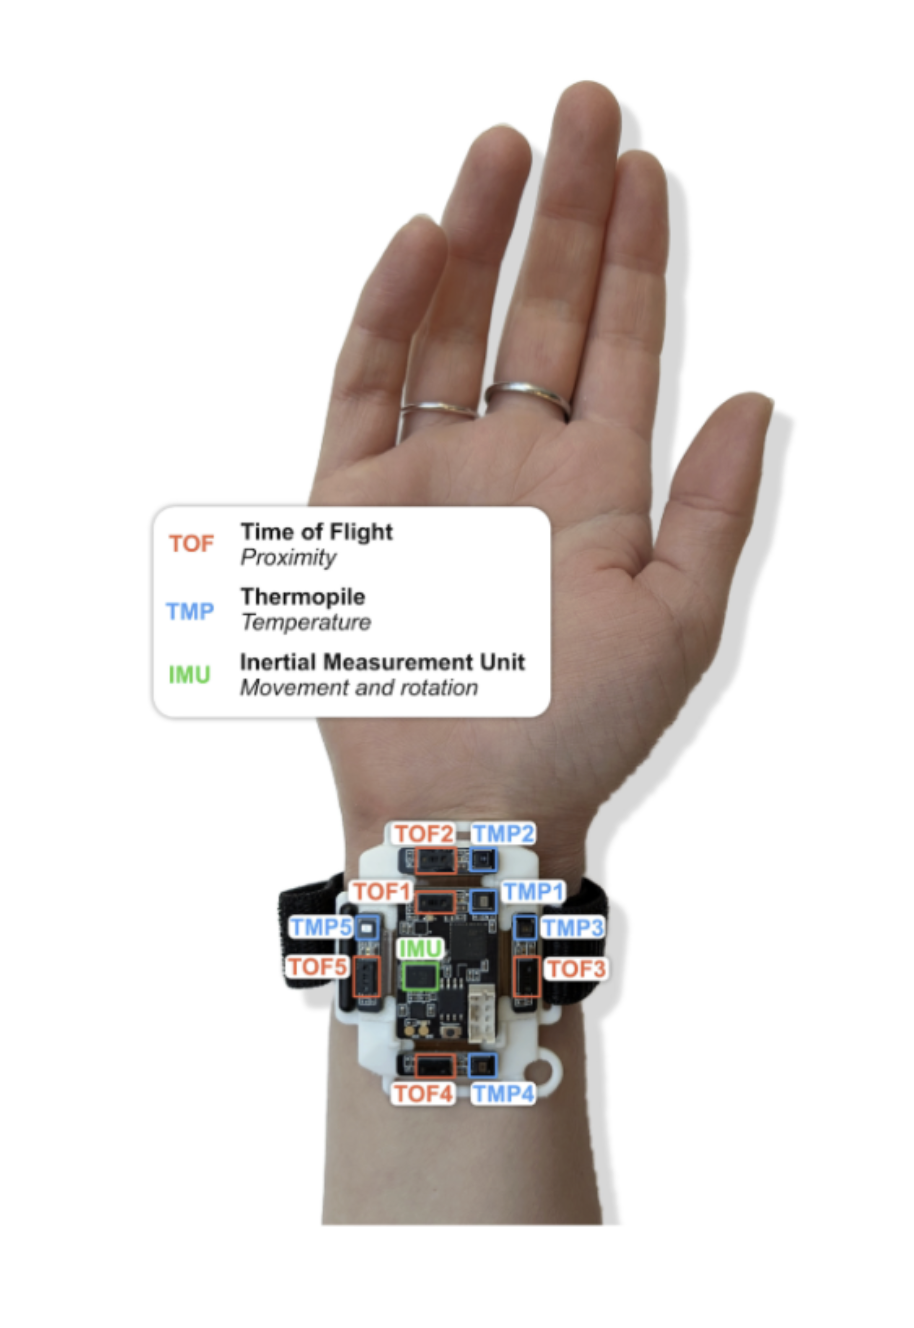

**✎  Gestures:**

*BFRB:*
Above ear - Pull hair, Forehead - Pull hairline, Forehead - Scratch, Eyebrow - Pull hair, Eyelash - Pull hair, Neck - Pinch skin, Neck - Scratch, Cheek - Pinch skin

*non-BFRB:*
Drink from bottle/cup, Glasses on/off, Pull air toward your face, Pinch knee/leg skin, Scratch knee/leg skin, Write name on leg, Text on phone, Feel around in tray and pull out an object, Write name in air, Wave hello

**✎  Credit:**

I would like to thank Ted Kyi and Ryan Chesler from the San Diego Machine Learning group for their help and guidance in tackling this problem, and more generally for the service they are doing for the San Diego community by teaching this highly valuable and sought-after skill to the public free of charge.
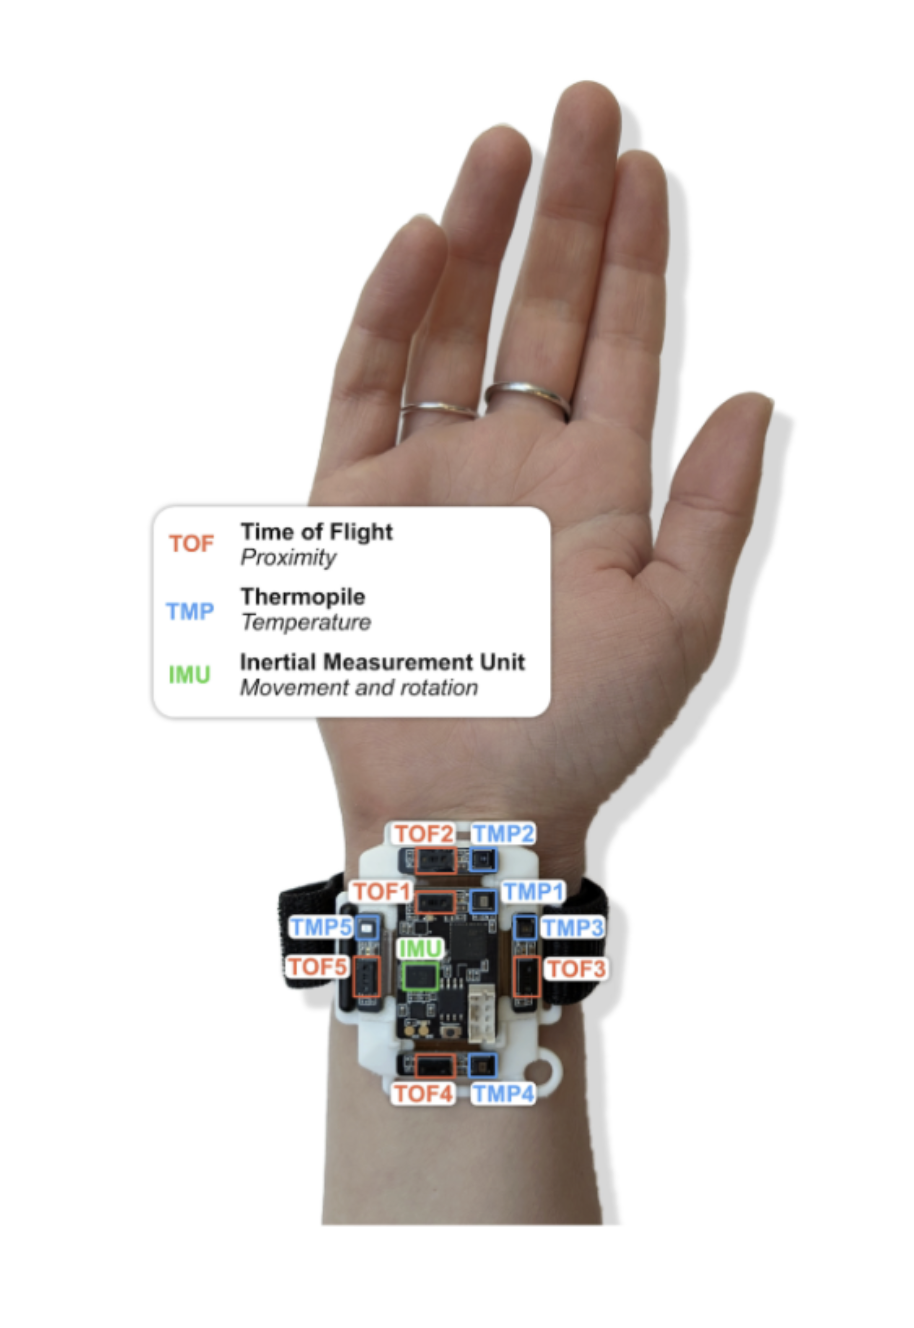
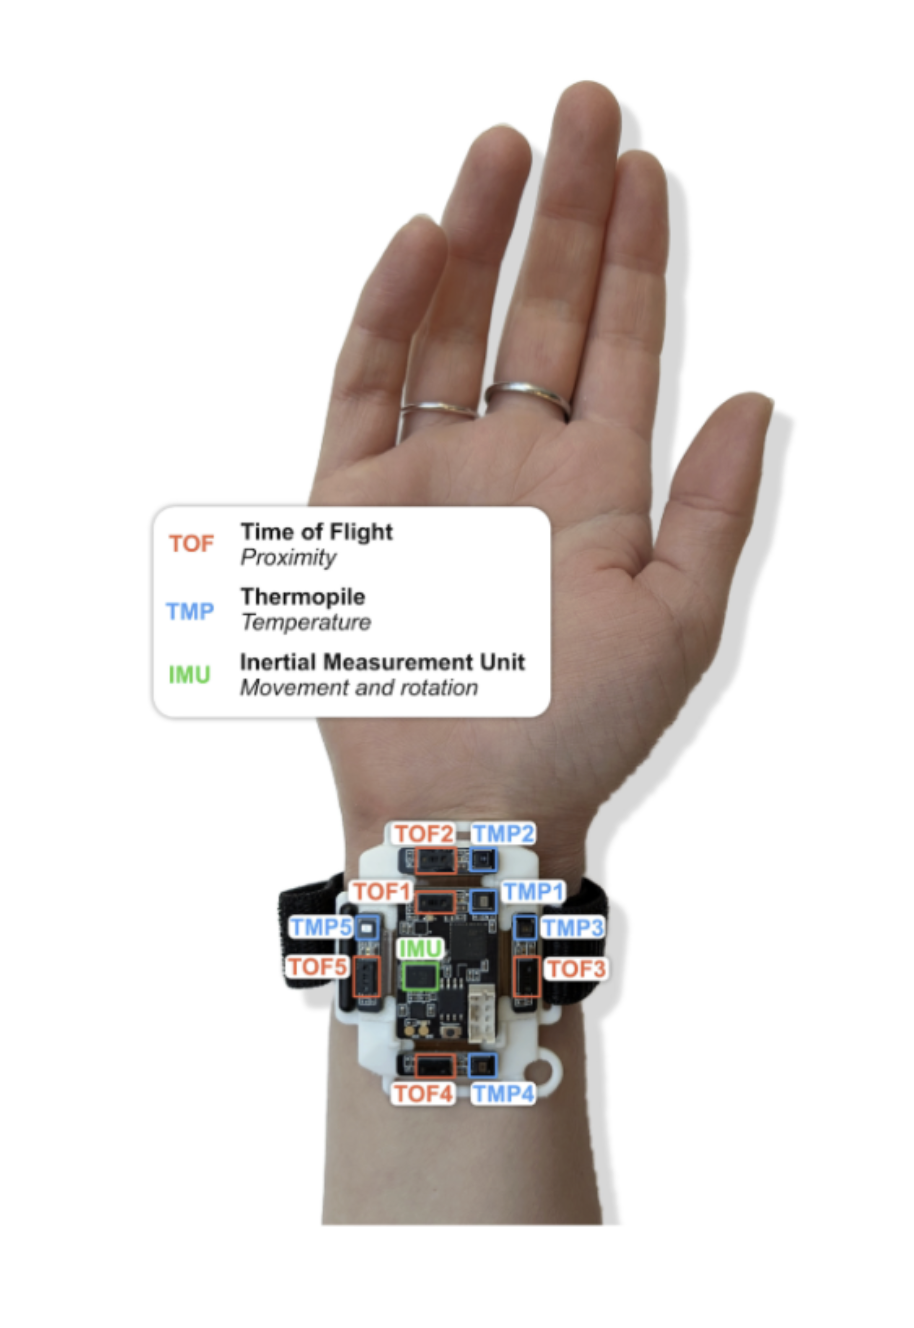

***

## ✨ Let's begin! ✨

In [1]:
import os
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from matplotlib.ticker import PercentFormatter
from matplotlib.cm import viridis
from matplotlib.colors import to_hex
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from scipy.spatial.transform import Rotation as R

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.DtypeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

A custom color palette for tables **(may not work in all formats) ✨**

In [2]:
# custom yellow-orange-bronze color palette
def apply_gold_standard_style(styler):
    styler.background_gradient(cmap='YlOrBr', low=0, high=1, subset=num_cols)
    styler.format('{:.2f}', subset=num_cols)
    styler.set_properties(subset=cat_cols, **{'color': 'black', 'background-color': 'white'})
    styler.set_properties(**{'text-align': 'center', 'font-size': '12px', 'border': '1px solid white'})
    styler.set_table_styles([{'selector': 'th', 'props': [('background-color', '#ffd700'),
        ('color', 'black'), ('font-weight', 'bold'), ('text-align', 'center'), ('font-size', '14px'),
        ('border', '1px solid white')]}])
    return styler

In [3]:
# load train data
train_placeholder = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/train.csv")
train = train_placeholder.copy()

print(f"Train shape: {train.shape}")
num_cols = train.select_dtypes(include='number').columns
cat_cols = train.select_dtypes(exclude='number').columns
display(train.head().style.pipe(apply_gold_standard_style))

Train shape: (574945, 341)


### Time-of-Flight Data

Here we can see that the darkness of the yellow corresponds to the relative size of the values within each column, and gives a visual indicator for how the data is changing between observations. Scrolling to the right will reveal just how many "TOF" columns there are in this dataset, 320 in total. 

These 320 columns are split into 5 groups of 64, each of which could be thought of as an 8x8 grid of pixels, with each observation corresponding to a pixel. The value of each observation measures the perpendicular distance between that pixel on the surface of the wrist-device and the nearest physical surface/object/person, ranging on a relative sale for non-missing values from 0-254. So essentially, this data creates 5 depth-maps, giving robust information of the subject's physical surroundings.

![TOF diagram](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F26856272%2F4efb2102b438d83fb3a65e135acaa14b%2FHelios_ToF_Grid_Fig.jpg?generation=1747669734957727&alt=media)

In addition to the sensor data, we also see some categorical indicator columns. Most of these just have to do with maintaining the structure of the dataset and will not be used in training, but some are interesting to investigate further. For example, the "phase" column separates each sequence into "transition" (transitioning into the gesture) and "gesture" (actually performing the gesture), and the "behavior" column further separates each sequence into "relaxes and moves hand to target location", "hand at target location", and "performs gesture".

In [4]:
# load train demographics data
train_demo = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/train_demographics.csv")

print(f"Train Demographics shape: {train_demo.shape}")
num_cols = train_demo.select_dtypes(include='number').columns
cat_cols = train_demo.select_dtypes(exclude='number').columns
display(train_demo.head().style.pipe(apply_gold_standard_style))

Train Demographics shape: (81, 8)


This is a separate demographics dataset that records some basic etrics about each subject in the study. Most of this is not that important (since we aren't training on it) but notice the "handedness" column - here "1" means right-handed and "0" means left-handed. Which arm the subject is wearing the device on completely flips the IMU data for that subject, so this is something we will need to account for.

In [5]:
# load test data
test = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv")

print(f"Test shape: {test.shape}")
num_cols = test.select_dtypes(include='number').columns
cat_cols = test.select_dtypes(exclude='number').columns
display(test.head().style.pipe(apply_gold_standard_style))

Test shape: (107, 336)


The test dataset is made up of only two sequences, from different subjects, each containing about 40-60 observations.

While the test dataset is an *indicator* for what we should expect to be evaluating our model on, **it is not the true test set**. The true test set is hidden from competition participants and is fed into our notebook for evaluation in sequences through a the competition evaluation API. We can be sure however that the true test set will also contain two sequences.

In [6]:
# load test demographics data
test_demo = pd.read_csv("/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv")

print(f"Test Demographics shape: {test_demo.shape}")
num_cols = test_demo.select_dtypes(include='number').columns
cat_cols = test_demo.select_dtypes(exclude='number').columns
display(test_demo.head().style.pipe(apply_gold_standard_style))

Test Demographics shape: (2, 8)


These are the corresponding demographics for the test set. We probably won't need this.

***

## 🧩 Some Unique Challenges for this Problem

Given the sequenced time-series format, sheer volume of features and complexity of the problem at hand, there are a number of unique challenges for this problem.

**✎  Righties vs. Lefties:**

As briefly mentioned, a small handful of participants are left-handed and therefore wore the Helios device on their left hand instead of their right. Since the test set does not indicate whether a subject is left-handed or right-handed, those specific subjects will have to be indentified using the demographics data, and then all of the IMU data for the sequences corresponding to those subjects will need to be transformed in order to align with the rest of the right-handed subjects.

**✎  Gravity:**

Gravity permeates all IMU data in this problem and can muddy our observations, so we will have to take it into account when engineering our features.

**✎  Bad Sequences:**

The sequences in this dataset vary immensely in length, with some having less than 15 observations and others having almost 700 - this is a major source of complexity for our model. One precaution we can take is to simply drop all sequences that fall below a certain length (say, 15 observations) - since the true test set will only contain 2 sequences, we can be fairly confident that a sequence that short will not appear in the true test set.

**✎  Varied Sequence Length:**

Since our model cannot take in sequences of different sizes, we will have to *pad* all sequences to have the same size. To account for the largest sequences, this means filling sequences with varying amounts of noise so that all sequences have an equal length (700 observations). The model should be able to pick up pretty quick that this is just extra noise not to be trained on.

**✎  Subjects #019262 and #045235:**

These two bozos decided to wear the wrist devices on their heads for the whole study (yes, seriously). This fact was observed in the first-place solution for this problem [which you can check out here](https://www.kaggle.com/competitions/cmi-detect-behavior-with-sensor-data/writeups/cmi-1st-place-solution). This data is likely not salvageable so I will remove those two subjects from the data entirely.

In [7]:
# remove subjects 019262 and 045235 from train and test datasets
train = train[train['subject'] != 'SUBJ_019262']
train = train[train['subject'] != 'SUBJ_045235']
test = test[test['subject'] != 'SUBJ_019262']
test = test[test['subject'] != 'SUBJ_045235']

In [8]:
# drop duplicate rows (if they exist)
print(f"Rows Missing Target Variable: {train['gesture'].isna().sum()}")
train.drop_duplicates(inplace=True)

Rows Missing Target Variable: 0


### Full IMU sequence
Below is an example of a full IMU sequence for a "Cheek - pinch skin" gesture, containing 51 observations.

In [9]:
# display example of an IMU sequence
seq_027987 = train[train['sequence_id'] == 'SEQ_027987'].copy()
seq_027987 = seq_027987.drop(["sequence_id", "subject", "orientation", "behavior"], axis=1)
seq_027987 = seq_027987.drop(seq_027987.loc[:, "thm_1" : "tof_5_v63"].columns, axis=1)
num_cols = seq_027987.select_dtypes(include='number').columns
cat_cols = seq_027987.select_dtypes(exclude='number').columns
display(seq_027987.head(52).style.pipe(apply_gold_standard_style))

***

## 🎨 EDA

Let us begin with some simple charts for viewing the demographic data.

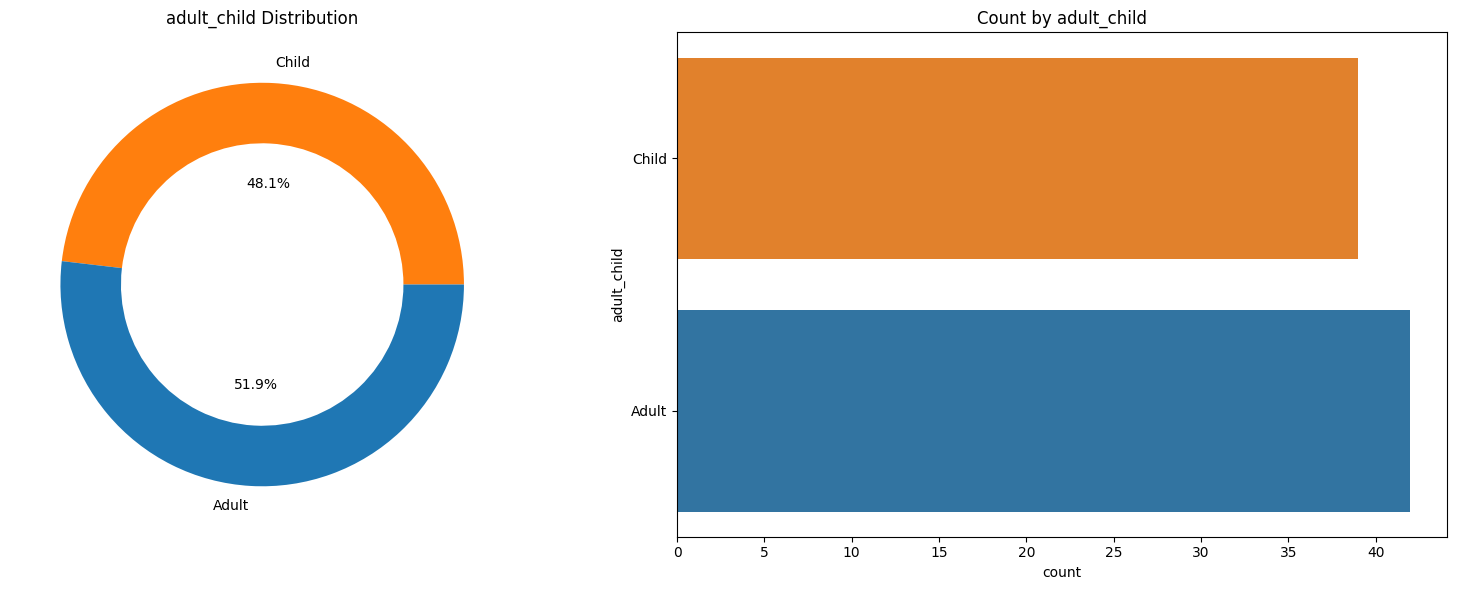

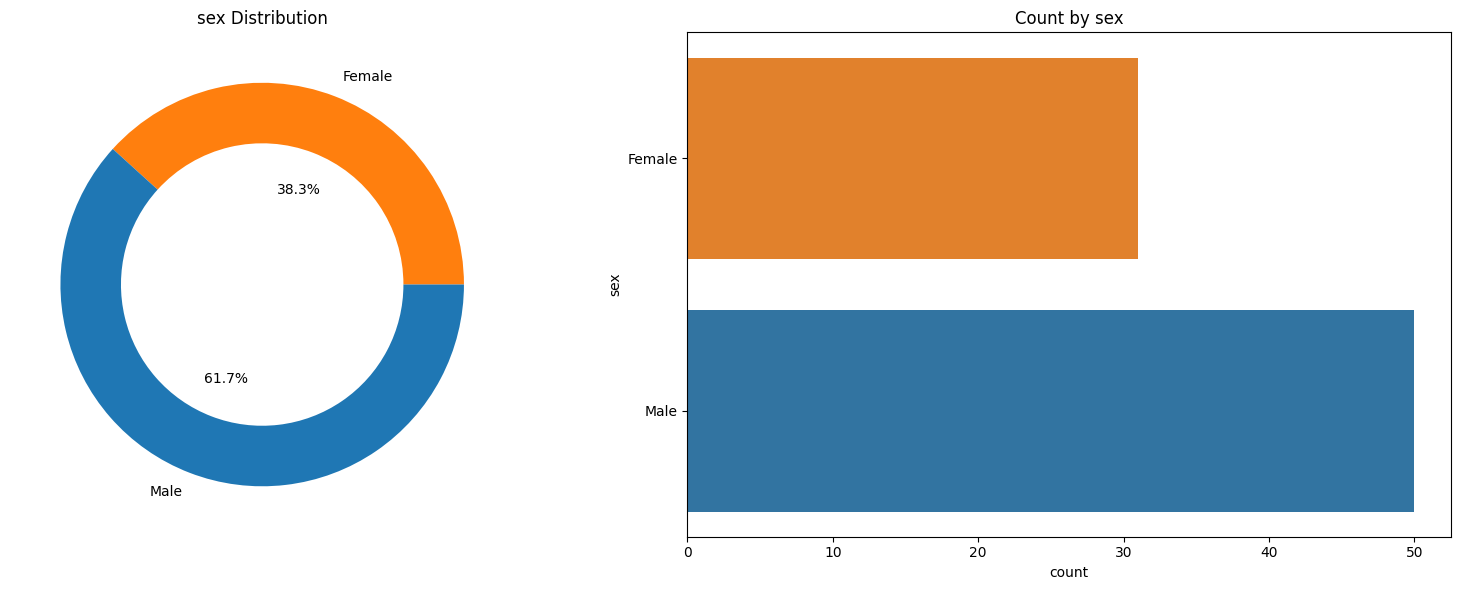

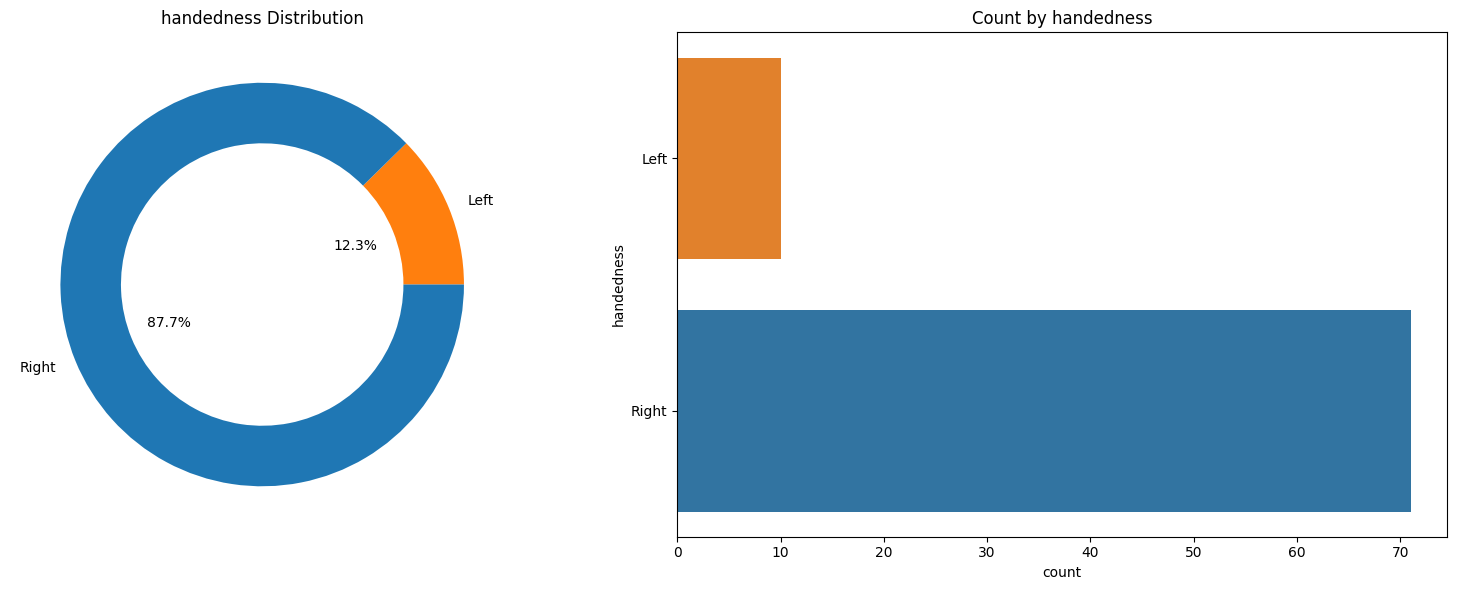

In [10]:
# categorical variables to analyze with respective value mappings
categorical_variables = ["adult_child", "sex", "handedness"]
value_mappings = {"adult_child": {0: "Child", 1: "Adult"}, "sex": {0: "Female", 1: "Male"}, "handedness": {0: "Left", 1: "Right"}}

# define plotting function for categorical variables
def plot_categorical(variable, data, value_mapping=None):

    colors = {0: '#ff7f0e', 1: '#1f77b4'}
    plt.figure(figsize=(16, 6))
    
    # get value counts and sort by index
    value_counts = data[variable].value_counts().sort_index()
    
    # create labels using the mapping if available, otherwise use original values
    labels = [value_mapping.get(i, str(i)) for i in value_counts.index]
    
    # pie chart
    plt.subplot(1, 2, 1)
    plt.pie(value_counts, autopct='%1.1f%%', colors=[colors.get(i, '#2ca02c') for i in value_counts.index], wedgeprops=dict(width=0.3), labels=labels, pctdistance=0.5)
    plt.title(f"{variable} Distribution")
    
    # countplot
    plt.subplot(1, 2, 2)
    ax = sns.countplot(data=data, y=variable, order=value_counts.index, palette=[colors.get(i, '#2ca02c') for i in value_counts.index])
    
    # update y-tick labels
    ax.set_yticklabels(labels)
    plt.title(f"Count by {variable}")
    plt.tight_layout()
    plt.show()

# generate plots for each categorical variable
for var in categorical_variables:
    if var in train_demo.columns:
        plot_categorical(variable=var, data=train_demo, value_mapping=value_mappings.get(var))

While this is the "Child Mind Institute", the subjects were about half and half children/adults. Dominance of right-handed subjects is no surprise - but notably, *the data is skewed male (60/40).*

Below are some distribution curves for IMU data. As this is positional time-series data, the values themselves are not very meaningful, but it is helpful to know what *range* these data follow.

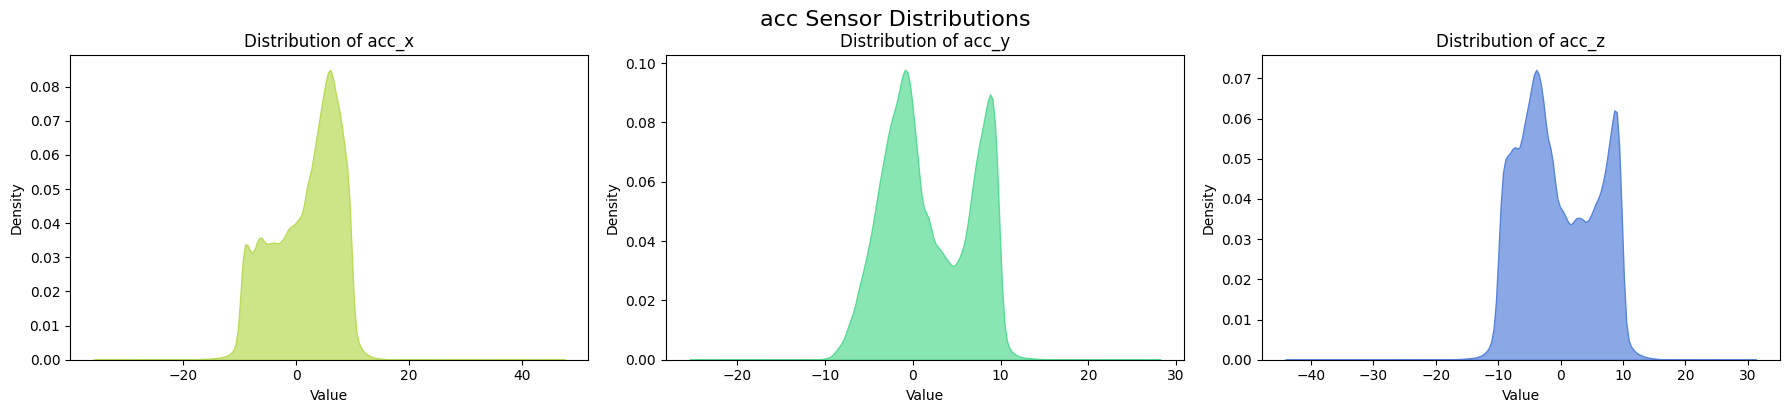



Summary Statistics for acc sensors:


count      mean       std        min       25%       50%       75%  \
acc_x  562688.0  1.722759  5.752787 -34.585938 -2.765625  3.074219  6.371094   
acc_y  562688.0  1.874918  4.978619 -24.402344 -2.074219  0.753906  6.906250   
acc_z  562688.0 -0.454414  6.096569 -42.855469 -5.421875 -1.562500  5.179688   

             max  
acc_x  46.328125  
acc_y  27.183594  
acc_z  30.078125

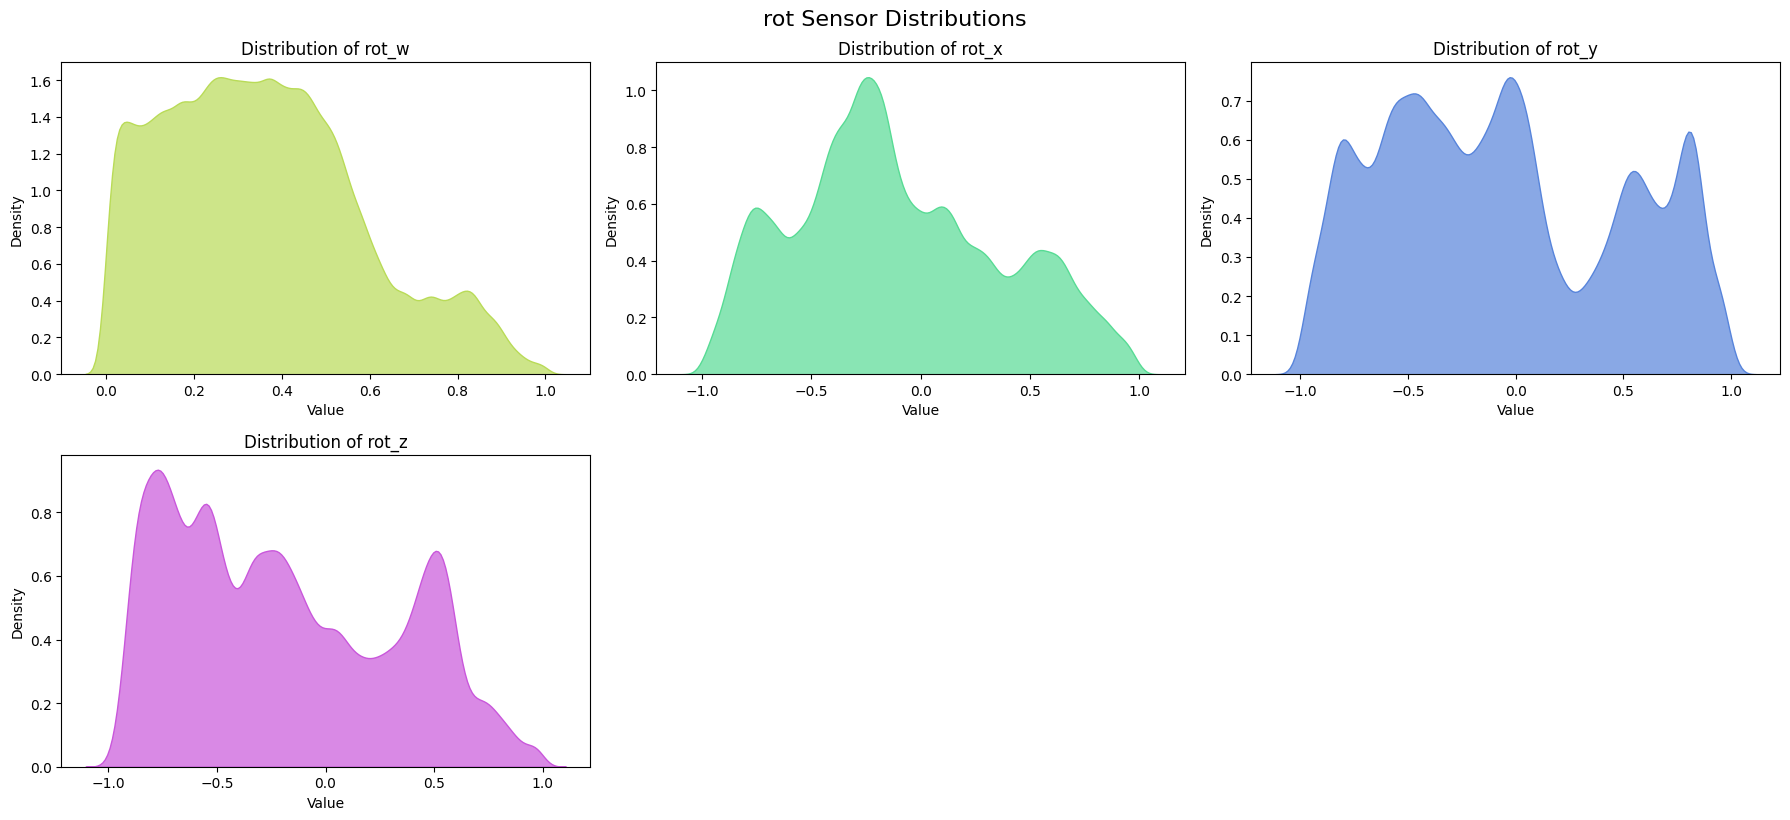



Summary Statistics for rot sensors:


count      mean       std       min       25%       50%       75%  \
rot_w  558996.0  0.357413  0.224144  0.000000  0.178406  0.337769  0.499939   
rot_x  558996.0 -0.113529  0.465845 -0.999146 -0.447388 -0.181763  0.214539   
rot_y  558996.0 -0.066103  0.543077 -0.999695 -0.514893 -0.122070  0.435547   
rot_z  558996.0 -0.194103  0.505111 -0.998169 -0.635437 -0.272949  0.245178   

            max  
rot_w  0.999390  
rot_x  0.999817  
rot_y  0.999451  
rot_z  0.999878

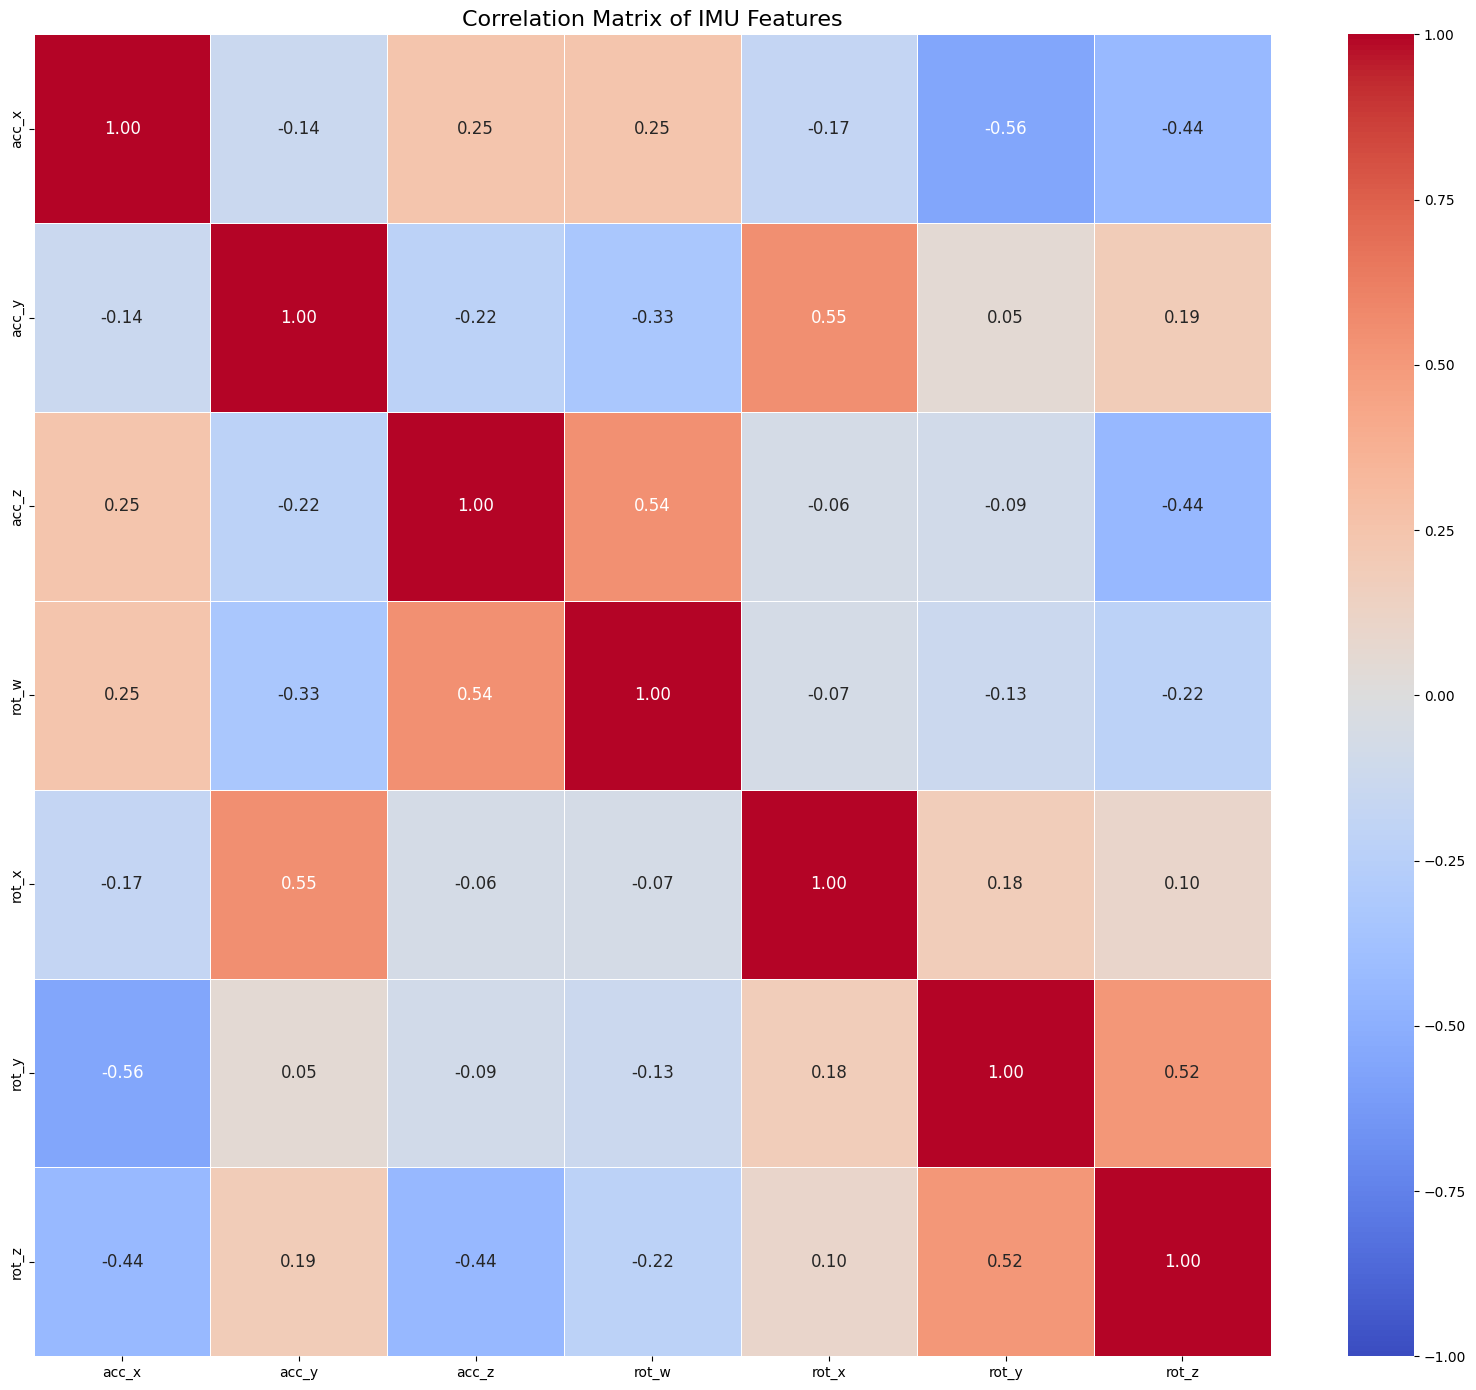

In [11]:
custom_palette = sns.color_palette("hls", n_colors=5)

# plotting density curve function
def plot_sensor_distributions(df, sensor_type, cols_per_row=3):
    sensor_cols = [col for col in df.columns if sensor_type in col]
    n_cols = len(sensor_cols)
    n_rows = (n_cols + cols_per_row - 1) // cols_per_row
    plt.figure(figsize=(18, 4 * n_rows))
    for i, col in enumerate(sensor_cols, 1):
        plt.subplot(n_rows, cols_per_row, i)
        sns.kdeplot(df[col].dropna(), fill=True, alpha=0.7, 
                    color=custom_palette[i % len(custom_palette)])
        plt.title(f'Distribution of {col}', fontsize=12)
        plt.xlabel('Value')
        plt.ylabel('Density')
    plt.tight_layout()
    plt.suptitle(f'{sensor_type} Sensor Distributions', y=1.02, fontsize=16)
    plt.show()
    print()
    print(f"\nSummary Statistics for {sensor_type} sensors:")
    display(df[sensor_cols].describe().T)
    print()
    print()

# visualize IMU distributions
plot_sensor_distributions(train, 'acc')
plot_sensor_distributions(train, 'rot')

# generate correlation heatmap
sensor_cols = [col for col in train.columns if 'acc' in col or 'rot' in col]
if sensor_cols:
    plt.figure(figsize=(16, 14))
    corr_matrix = train[sensor_cols].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0, vmin=-1, vmax=1, linewidths=0.5, annot_kws={"fontsize": 12})
    plt.title('Correlation Matrix of IMU Features', fontsize=16)
    plt.tight_layout()
    plt.show()

The correlation matrix reveals the intuitive relationship between acceleration and orientation data - notice the magnitudes right above the bottom-left/top-right diagonal. We can also see interdependence of the orientation features, and the mostly independent nature of the acceleration features.

### Missingness

Let us now take a look at what is missing from our provided dataset. You'll notice the overwhelming majority of missing values come from the TOF columns, which contain roughly 50% missing data. Not only that, but missingness within each depth map follow a pattern, either increasing or decreasing at the same interval. It's quite a cool thing to look at.

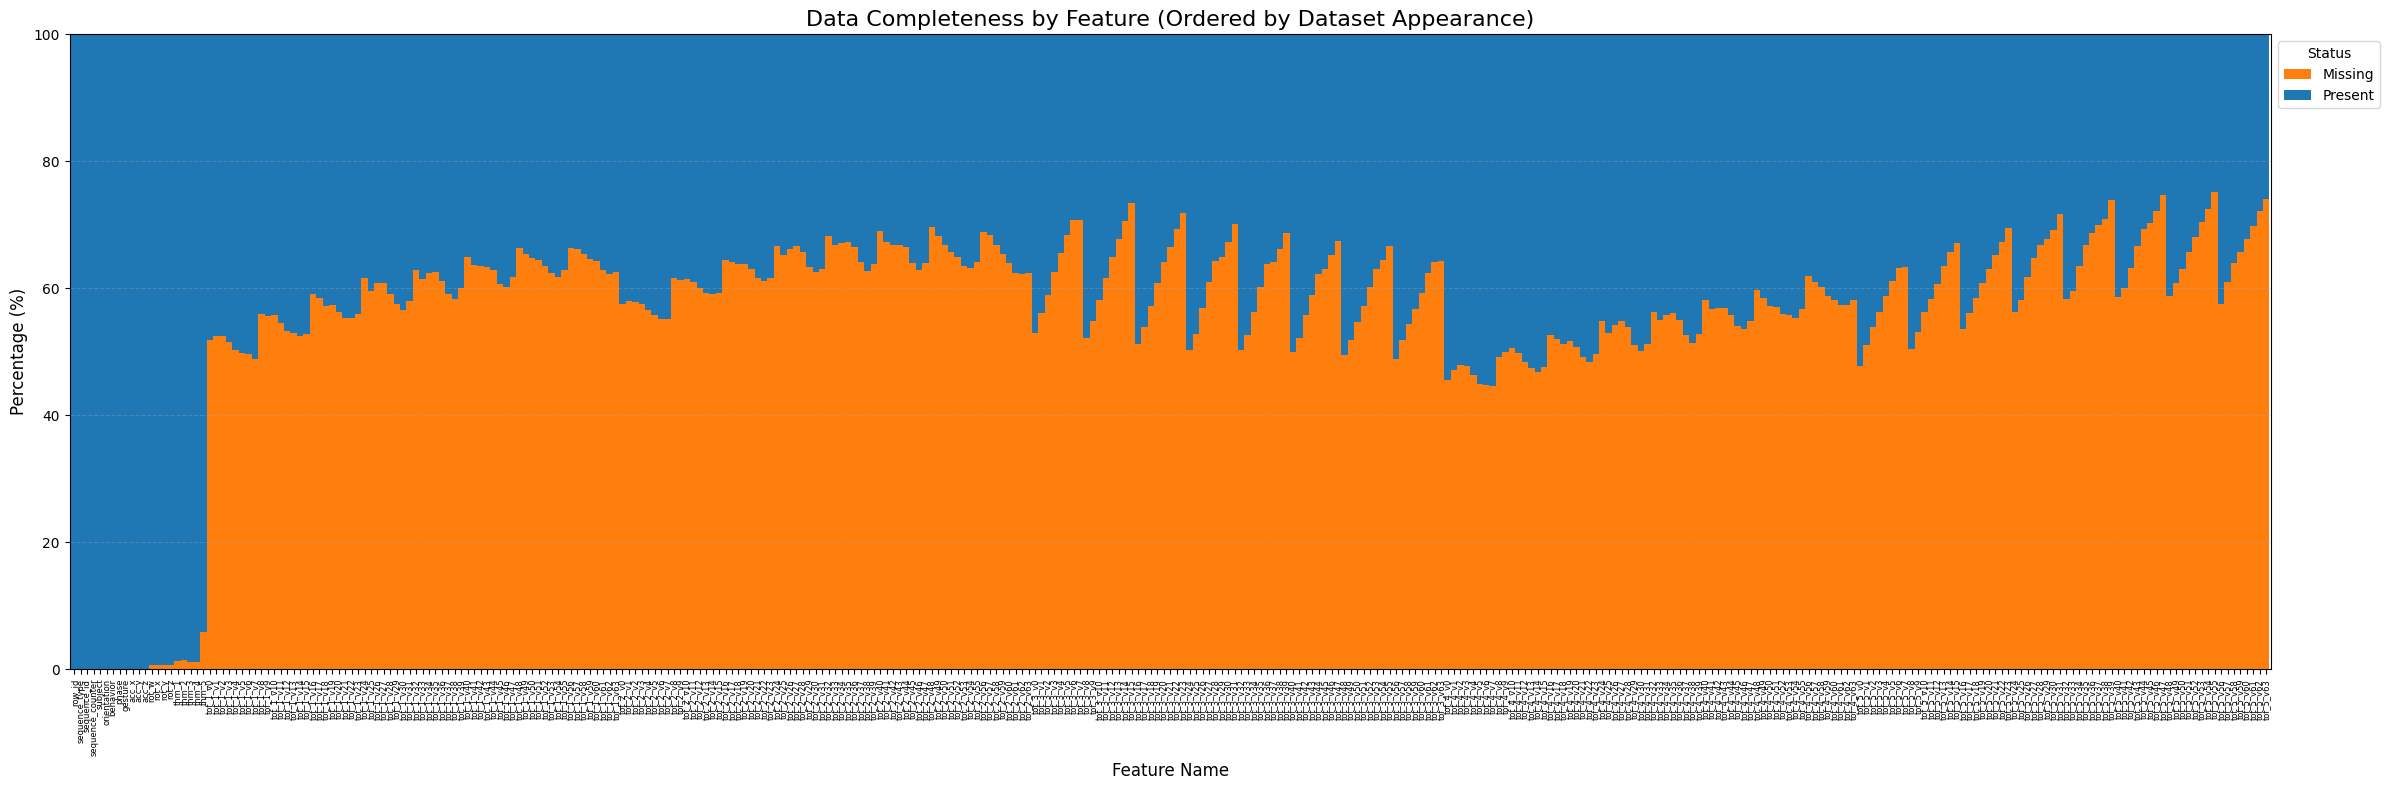

In [12]:
# replace -1 and 0 with NaN in Time-of-Flight columns
tof_cols = [c for c in train.columns if c.startswith('tof_')]
train[tof_cols] = train[tof_cols].replace([-1, 0], np.nan)
test[tof_cols] = test[tof_cols].replace([-1, 0], np.nan)

# calculate missingness
missing_pct = train.isnull().mean() * 100
completeness_df = pd.DataFrame({'Missing': missing_pct,'Present': 100 - missing_pct})

# generate stacked bar chart
plt.figure(figsize=(24, 8)) 
ax = completeness_df.plot(kind='bar', stacked=True, color=['#ff7f0e', '#1f77b4'], width=1.0, ax=plt.gca())
plt.title('Data Completeness by Feature (Ordered by Dataset Appearance)', fontsize=16)
plt.ylabel('Percentage (%)', fontsize=12)
plt.xlabel('Feature Name', fontsize=12)
plt.ylim(0, 100)
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left', title='Status')
plt.xticks(rotation=90, fontsize=6)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

So much missingess in these columns poses another potential issue for the model - it will have to learn how to intelligently work around so much useless data. Essentially, feeding it this whole sequence but wanting it only to learn from the blue area.

Since the TOF data is measuring distance from a given pixel to the nearest object, an intelligent way to impute this missing data is to fill it with an arbitrary large number like 400. This is basically saying to the model "there is nothing anywhere near this pixel". Because this gives the model as little information as possible, it will learn to ignore it. 

If we left missing values as 0, the model *might* learn to ignore these values due to the sheer number of them, but since 0 also means "there is something pressed up against this pixel", the model might get overwhelmed and take these values seriously, which would cause problems.

In [13]:
from sklearn.impute import SimpleImputer

# impute missing rot values with 0
rots = ["rot_w", "rot_x", "rot_y", "rot_z"]
train[rots] = train[rots].fillna(0)

# fill missing temperature data with average by column
thms = ["thm_1", "thm_2", "thm_3", "thm_4", "thm_5"]
imputer = SimpleImputer(strategy='constant', fill_value=0)
train[thms] = imputer.fit_transform(train[thms])

# fill all NaNs in time-of-flight (ToF) columns with 400
tof_train = train.loc[:, "tof_1_v0" : "tof_5_v63"].columns
train[tof_train] = train[tof_train].fillna(400)
tof_test = test.loc[:, "tof_1_v0" : "tof_5_v63"].columns
test[tof_test] = test[tof_test].fillna(400)

### Gestures

One particular feature of the competition is that the gestures are not evenly distributed throughout the data. Some gestures appear much more frequently than others - this introduces another layer of complexity for the model.

Recall here that "target" gestures are our BFRB-like gestures. The notion of a "target variable" is not totally relevant in this project since the model in the end will predict the exact gesture itself, but for now let us stick with this convention.

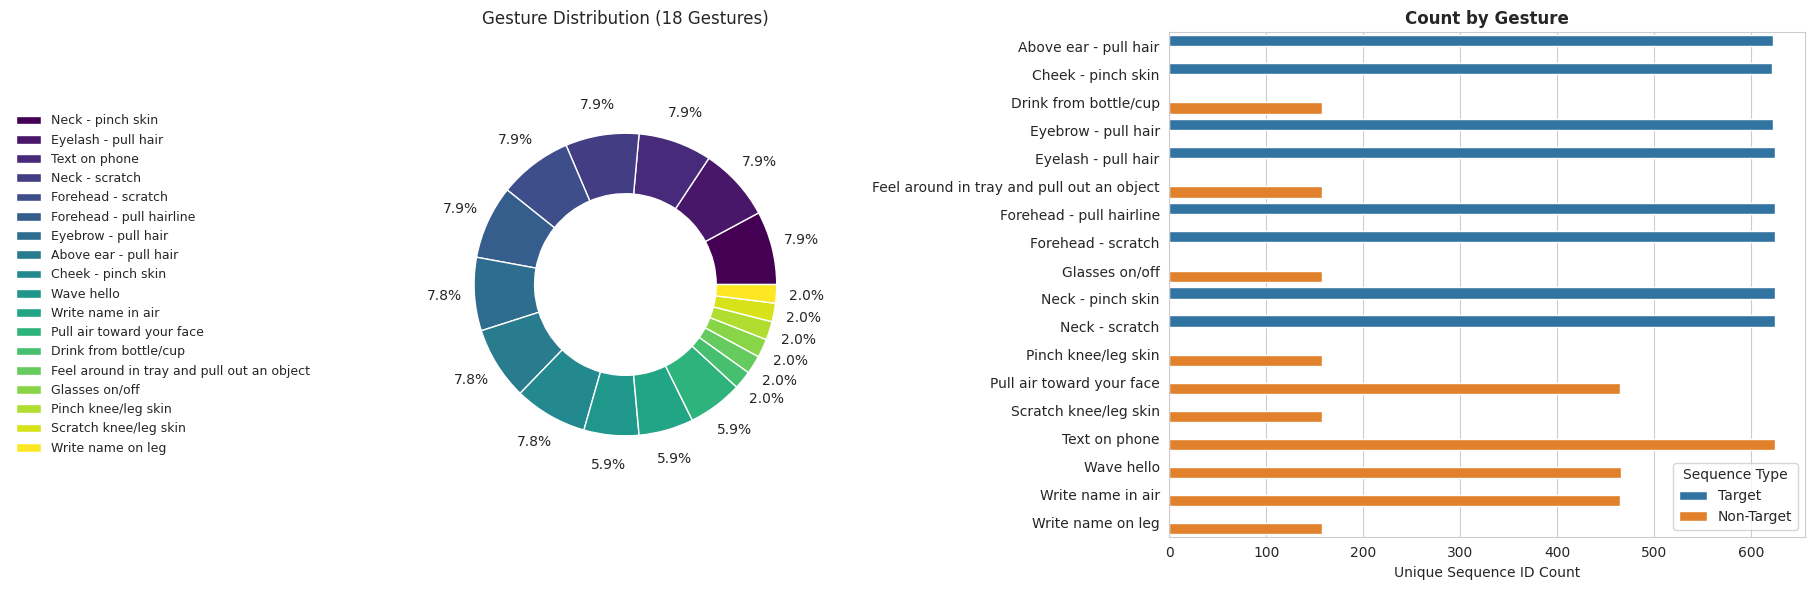

In [14]:
sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# gesture distribution donut chart
value_counts = train.groupby('gesture')['sequence_id'].nunique().sort_values(ascending=False)
num_gestures = len(value_counts)
palette = [to_hex(viridis(i / (num_gestures - 1))) for i in range(num_gestures)]
ax1.pie(value_counts, autopct='%1.1f%%', colors=palette, radius=0.75, wedgeprops={'width': 0.3}, pctdistance=1.2)
ax1.legend(value_counts.index, bbox_to_anchor=(-0.1, 0.5), loc='center right', prop={'size': 9}, frameon=False, borderpad=0.5, labelspacing=0.5)
ax1.set_title(f"Gesture Distribution ({num_gestures} Gestures)")
group_df = train.groupby(['gesture', 'sequence_type'])['sequence_id'].nunique().reset_index()

# generate bar count plot
sns.barplot(data=group_df, y='gesture', x='sequence_id', hue='sequence_type', palette=['#1f77b4', '#ff7f0e'], ax=ax2)
ax2.set(xlabel='Unique Sequence ID Count', ylabel='')
ax2.legend(title='Sequence Type')
ax2.set_title("Count by Gesture", fontweight='bold')

plt.tight_layout()
plt.show()

There actually appear to be distinct levels of frequency. We can see that the non-BFRB-like leg gestures (Write name on leg, Scratch knee/leg skin, Pinch knee/leg skin) are the least frequent and that many of the BFRB-like gestures that involve touching the face (Neck - pinch skin, Eyelash - pull hair, Forehead - scratch) are the most frequent. 

### Visualizing Gestures

I also thought it would be interesting to visualize the gestures themselves as another way of understanding what kind of information the model will be learning from. Here is a selection of gestures from subject #023739 represented using *acceleration magnitude* and *rotation angle* over the course of the gesture.

Acceleration magnitude is simply the strength of acceleration in any direction - rotation angle can be thought of as "the total deviation from home", "home" being some arbitrary resting place.

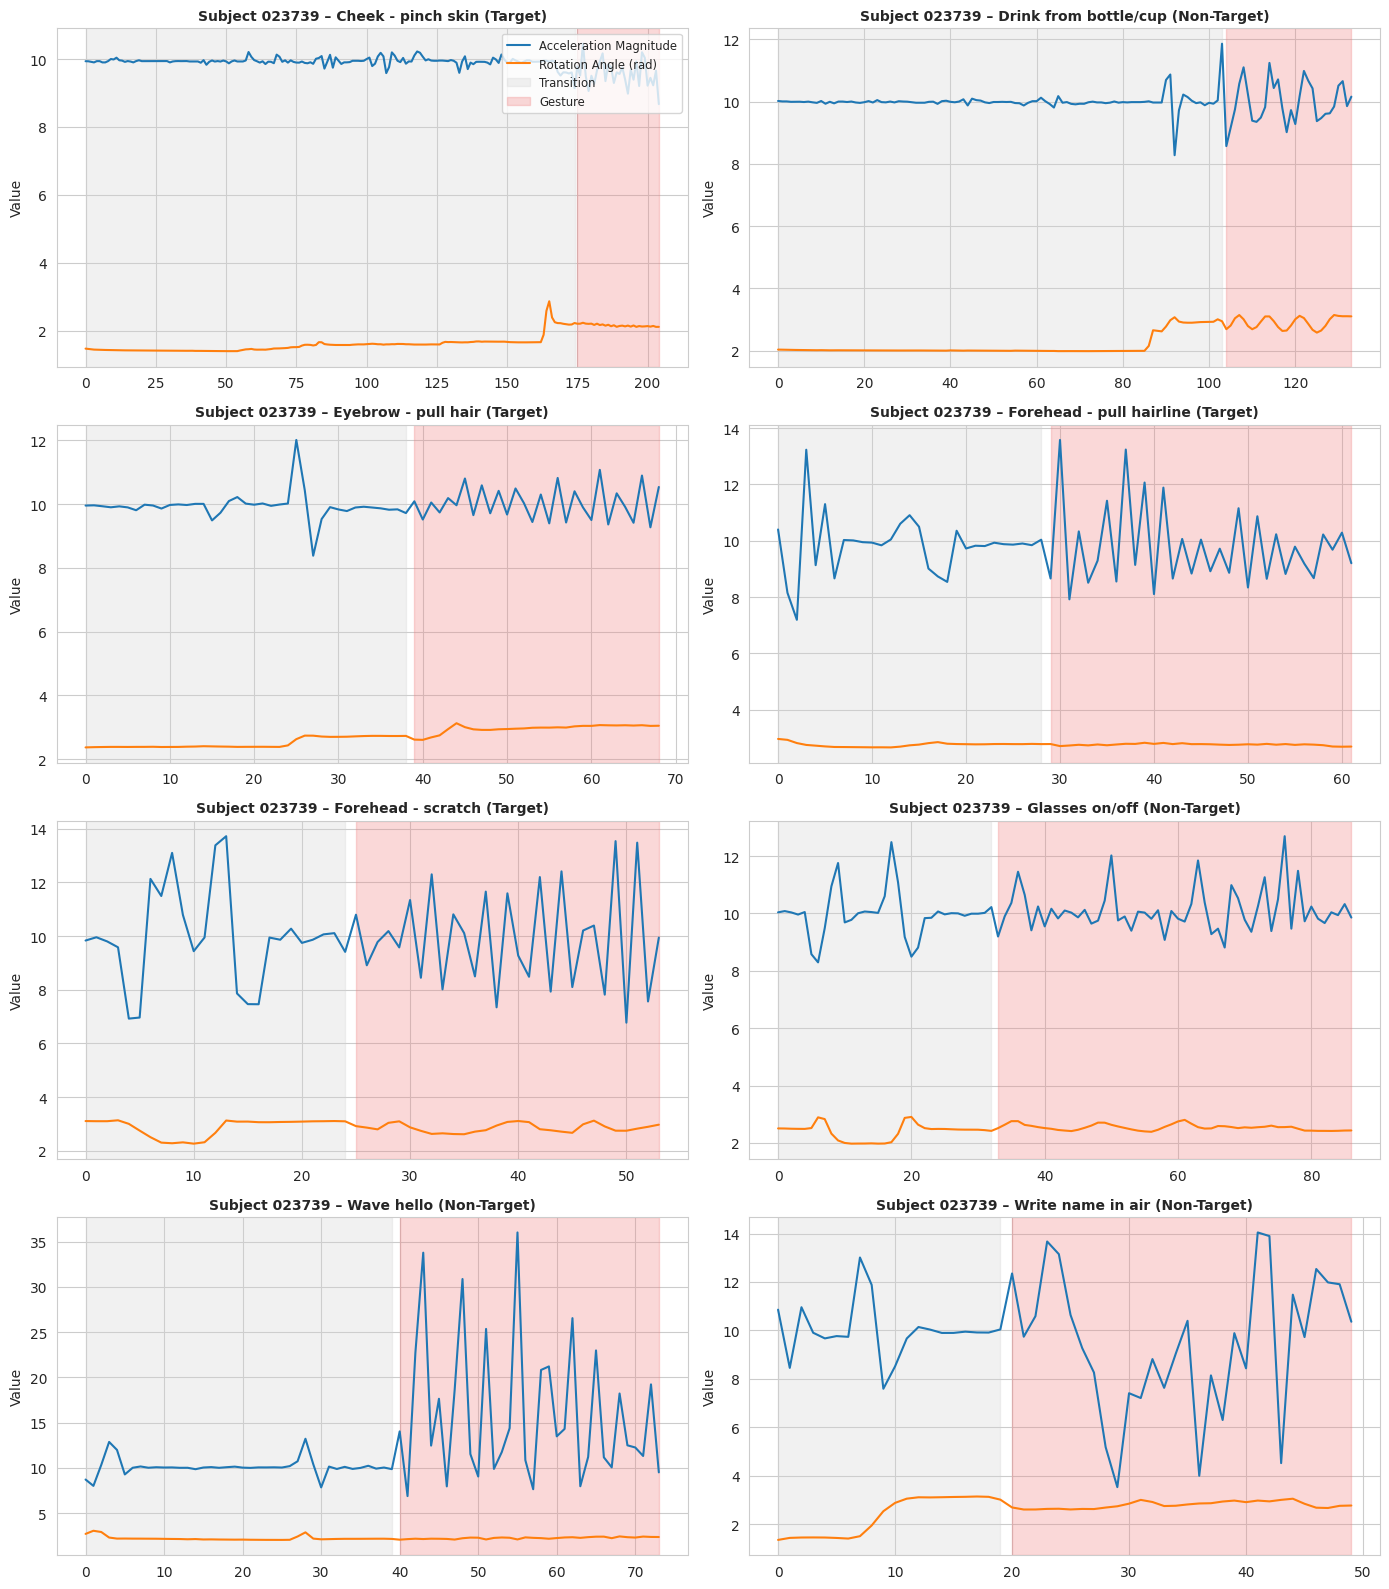

In [15]:
# GESTURE SAMPLE ANALYSIS FROM SUBJECT 023739

# compute features
subj_023739 = train[train['subject'] == 'SUBJ_023739'].copy()
subj_023739['acc_mag'] = np.sqrt(subj_023739[['acc_x', 'acc_y', 'acc_z']].pow(2).sum(axis=1))
subj_023739['rot_angle'] = 2 * np.arccos(subj_023739['rot_w'].clip(-1, 1))

# get one sequence per gesture
selected_gestures = ["Cheek - pinch skin", "Drink from bottle/cup", "Eyebrow - pull hair", "Forehead - pull hairline", "Forehead - scratch", "Glasses on/off", "Wave hello", "Write name in air"]
seq_ids = subj_023739[subj_023739['gesture'].isin(selected_gestures)].groupby('gesture')['sequence_id'].first().values

# setup figure
n = len(seq_ids)
ncols = 2
nrows = int(np.ceil(n / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4 * nrows), squeeze=False)
axes = axes.flatten()

# plot data
for i, seq in enumerate(seq_ids):
    ax = axes[i]
    df = subj_023739[subj_023739['sequence_id'] == seq].sort_values('sequence_counter')
    times = df['sequence_counter']
    ax.plot(times, df['acc_mag'], label='Acceleration Magnitude', color='tab:blue')
    ax.plot(times, df['rot_angle'], label='Rotation Angle (rad)', color='tab:orange')
    
    # add phase shading
    for phase, color in [('Transition', 'lightgray'), ('Gesture', 'lightcoral')]:
        mask = df['phase'] == phase
        idxs = np.where(mask)[0]
        for start, end in zip(np.concatenate(([0], np.where(np.diff(idxs) > 1)[0] + 1)), np.concatenate((np.where(np.diff(idxs) > 1)[0], [len(idxs)-1]))):
            t0, t1 = df.iloc[idxs[start]]['sequence_counter'], df.iloc[idxs[end]]['sequence_counter']
            ax.axvspan(t0, t1, color=color, alpha=0.3, label=phase if phase not in ax.get_legend_handles_labels()[1] else None)
    
    # format subplot
    ax.set_title(f"Subject 023739 – {df['gesture'].iloc[0]} ({df['sequence_type'].iloc[0]})", fontsize=10, fontweight='bold')
    ax.set(xlabel="", ylabel="Value")
    ax.legend(loc='upper right', fontsize='small').set_visible(i == 0)
    ax.grid(True)

# clean up and show
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

It's fun to look at these graphs and try to mimic the gestures yourself. This is relatively easy to do for most of them (like "drink from bottle/cup" or "wave hello"), but in others can be a bit more difficult to follow (like "write name in air"). Not all gestures are obvious and some seem to have unusual spikes/detours, like the big spike that occurs between observations 20-30 in "eyebrow - pull hair". Did that subject have a spasm before they began performing the gesture?

We are beginning to see that our model has a lot to figure out. It will have to learn to look past things like the big spike in the "eyebrow - pull hair" gesture and say *yes, I see this jolt at the start of the sequence, but I still think that this is "eyebrow - pull hair"*. Thankfully, this is exactly what neural networks are good at.

Just for fun, I have also created 3D rendering showing the acceleration data for subject #052342 performing the "Wave hello" gesture.

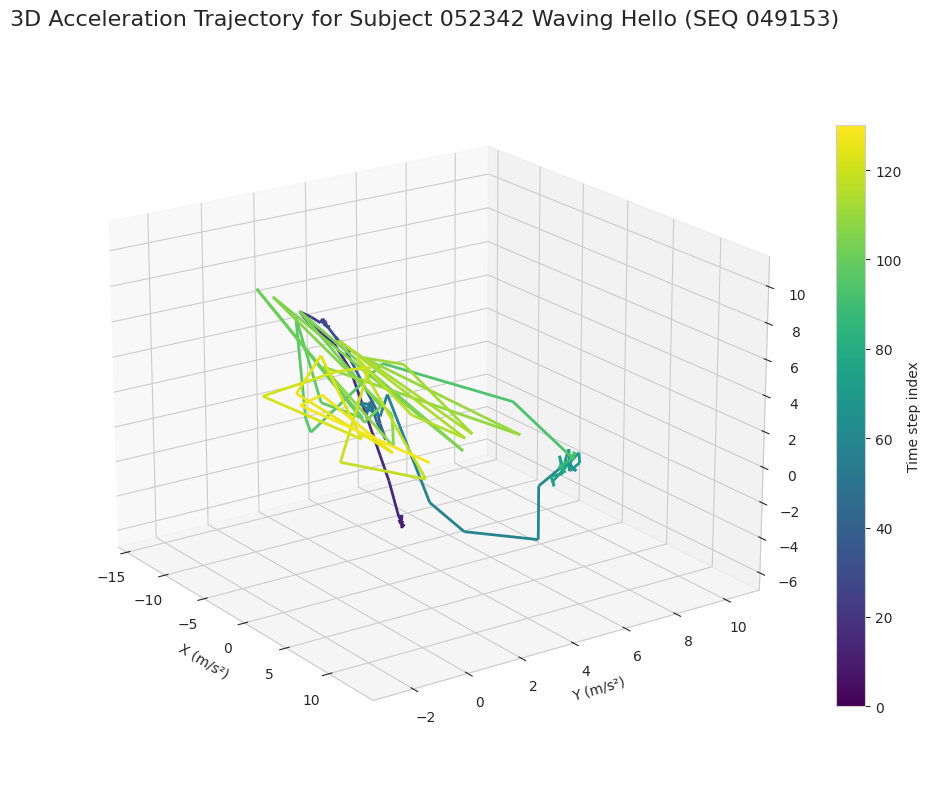

In [16]:
# 3D RENDERING OF ACCELERATION TRAJECTORY FOR SUBJECT 052342 WAVING "HELLO"

seq_049153 = train[train['sequence_id'] == 'SEQ_049153'].copy()
x_data = seq_049153['acc_x'].values
y_data = seq_049153['acc_y'].values
z_data = seq_049153['acc_z'].values

# plot 3D trajectory
def plot_3d_trajectory(x, y, z, title="3D Trajectory"):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    time_steps = np.arange(len(x))
    points = np.array([x, y, z]).T.reshape(-1, 1, 3)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = plt.get_cmap('viridis')
    lc = Line3DCollection(segments, cmap=cmap, norm=plt.Normalize(0, len(time_steps)))
    lc.set_array(time_steps)
    lc.set_linewidth(2)
    ax.add_collection3d(lc)

    # add a color bar
    mappable = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(time_steps)))
    mappable.set_array([])
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.8)
    cbar.set_label('Time step index')

    # customize the plot
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_xlabel('X (m/s²)')
    ax.set_ylabel('Y (m/s²)')
    ax.set_zlabel('')

    # final details
    buffer = 1.5
    ax.set_xlim(x.min() - buffer, x.max() + buffer)
    ax.set_ylim(y.min() - buffer, y.max() + buffer)
    ax.set_zlim(z.min() - buffer, z.max() + buffer)
    ax.view_init(elev=20., azim=-35)
    ax.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_3d_trajectory(x_data, y_data, z_data, title="3D Acceleration Trajectory for Subject 052342 Waving Hello (SEQ 049153)")

It's nice that this particular sequence has little transition time because it makes the gesture so clearly visible. We can follow it easily - the subject brings their hand up in the first 40 observations, swoops it around swoops it around for the next 40, and then waves back-and-forth, albeit a little haphazardly, for the rest of the sequence... I'm guessing subject #052342 is a child! 🙋

### Bad Sequences

As mentioned before, overly short sequences might confuse the model. Filtering out 2,644 bad sequences where each sequence contains 15 observations or less means that we have removed *at least* 176 bad sequences from our dataset.

In [17]:
# filter out short gesture sequences (bad data)
print("Before filtering:", train.shape)
gesture_counts = ((train['phase'] == 'Gesture').groupby(train['sequence_id']).transform('sum'))
train = train[gesture_counts >= 15].reset_index(drop=True)
print("After filtering:",train.shape)

Before filtering: (562688, 341)
After filtering: (560044, 341)


### 🫱 Taking account for the Lefties

A quick look at the demographics dataset reveals that the following subjects are left-handed and need to be converted into a right-handed frame for their data to be usable:

- **002923**
- **013623**
- **019756**
- **028998**
- **032233**
- **032585**
- **039234**
- **041243**
- **055211**
- **061552**

Since gestures are recorded in various positions, it is impossible to be completely precise about how a left-handed action would be converted to a right-handed frame. A good generalization is to rotate the acceleration data by 180 degrees (clean conversion from left to right) and rotate the orientation data by about 90 degrees - *why 90?*

Imagine you are wearing a watch and sitting with both of your hands resting on a table. *Is the watch facing directly up towards the ceiling?* Probably not, at least not most of the time - it's probably resting about 45 degrees between facing the ceiling and being perpendicular to the table. So, switching the watch from hand to the other would be a 90 degree rotation, not 180. Of course, we're not assuming that all sequences are recorded with subjects sitting at a table - but considering the fact that we have to account for 4 different positions, this is a fine middle ground solution.

In [18]:
# STANDARDIZE LEFT HAND TO MATCH RIGHT HAND

lefties = ["SUBJ_002923", "SUBJ_013623", "SUBJ_019756", "SUBJ_028998", "SUBJ_032233", "SUBJ_032585", "SUBJ_039234", "SUBJ_041243", "SUBJ_055211", "SUBJ_061552"]
lefty_mask = train.subject.isin(lefties)

# transform acceleration data
train.loc[lefty_mask, 'acc_y'] = -train.loc[lefty_mask, 'acc_y']
train.loc[lefty_mask, 'acc_z'] = -train.loc[lefty_mask, 'acc_z']

# transform orientation data
q_original = train.loc[lefty_mask, ['rot_w', 'rot_x', 'rot_y', 'rot_z']].copy()
train.loc[lefty_mask, 'rot_w'] = -q_original['rot_x']
train.loc[lefty_mask, 'rot_x'] =  q_original['rot_w']
train.loc[lefty_mask, 'rot_y'] = -q_original['rot_z']
train.loc[lefty_mask, 'rot_z'] =  q_original['rot_y']

What about non-IMU data, like the Time-of-Flight sensors? While it is true that they would record different information if on different hands, without any information on what the subjects' surroundings *are*, we have no way interpolating that data from what we currently have. So we leave that as is, even if it's technically wrong - and besides, we're probably starting to get too in the weeds here.

***

## 👷 Feature Engineering

Deciding on what features to create is a tricky and cautious process, but for this problem creating features from the IMU features will be most valuable due to their interdependence as well as the number of derivatives and sub-measurements we can take.

The five temperature sensors measure a singular piece of data, temperature, which doesn't really have any obvious relationships with other features in the data - for instance, I don't think a feature like "change in temperature over acceleration magnitude" would be of much help to the model.

The TOF data on the other hand is so mind-bogglingly complex that I think for me, any way to try and engineer something clever from those 320 columns would end in disaster. Maybe it could be done, but I wouldn't know where to begin.

In [19]:
import random

# create validation set
sequences = train['sequence_id'].unique().tolist()
val_sequences = random.sample(sequences, int(len(sequences) * 0.2))
validation = train[train['sequence_id'].isin(val_sequences)].copy()
train = train[~train['sequence_id'].isin(val_sequences)].reset_index(drop=True)

In [20]:
# define irrelevant columns
columns_to_drop = ['row_id', 'sequence_type', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase']

# remove irrelevant columns from train, test and validation sets (leaving backup validation for evaluation)
train = train.drop(columns=[col for col in columns_to_drop if col in train.columns])
validation = validation.drop(columns=[col for col in columns_to_drop if col in validation.columns])
test = test.drop(columns=[col for col in columns_to_drop if col in test.columns])

# create set list
sets = [train, test, validation]

### New Features ⚙️

**✎  Linear acceleration (acceleration without gravity):** lin_acc_x, lin_acc_y, lin_acc_z

We remove gravity by defining a gravity vector [0, 0, 9.81], rotating it based on the orientation of the device, and then subtracting it from the acclereation features (as a vector) component-wise. To give the model as much information as possible, we will keep the regular acceleration features.

**✎  Acceleration magnitude:** acc_mag, lin_acc_mag

Simply the strength of the total acceleration in any direction.

**✎  Magnitude jerk:** acc_mag_jerk, lin_acc_mag_jerk

Jerk is the derivative of acceleration. We will stick to calculating jerk on only the magnitudes.

**✎  Rotation angle:** rot_angle

This can be thought of as the total distance from some arbitrary point in space at which the device is centered.

**✎  Angular distance:** angular_distance

Angular distance measures the magnitude of change in the rotation data between observations. It can be thought of as a derivative like jerk.

**✎  Angular velocity:** angular_vel_x, angular_vel_y, angular_vel_z

Angular velocity measures the speed that the device is spinning at each observation along a given axis.

**✎  Rotation angle velocity:** rot_angle_vel

This measures the speed at which the wrist device is spinning in any given direction at each observation.

In [21]:
# de-fragment train/test/val sets (for memory)
train = train.copy()
test = test.copy()
validation = validation.copy()

# consolidated calculation of features
def calculate_sequence_features(group):
    acc = group[['acc_x', 'acc_y', 'acc_z']].values
    rot = group[['rot_x', 'rot_y', 'rot_z', 'rot_w']].values
    time_step = 0.1
    gravity_world = np.array([0, 0, 9.81])
    new_feats = {}

    # -> SIMPLE FEATURES
    # linear acceleration (acceleration w/ gravity removed)
    norms = np.linalg.norm(rot, axis=1)
    valid_mask = norms > 1e-6
    lin_acc = acc.copy()
    
    if np.any(valid_mask):
        q_norm = rot[valid_mask] / norms[valid_mask][:, None]
        r = R.from_quat(q_norm)
        g_sensor = r.apply(gravity_world, inverse=False)
        lin_acc[valid_mask] = acc[valid_mask] - g_sensor

    new_feats['lin_acc_x'] = lin_acc[:, 0]
    new_feats['lin_acc_y'] = lin_acc[:, 1]
    new_feats['lin_acc_z'] = lin_acc[:, 2]

    # magnitudes of acceleration
    acc_mag = np.linalg.norm(acc, axis=1)
    lin_acc_mag = np.linalg.norm(lin_acc, axis=1)
    new_feats['acc_mag'] = acc_mag
    new_feats['lin_acc_mag'] = lin_acc_mag

    # jerk features (derivatives [gradient] of magnitudes)
    new_feats['acc_mag_jerk'] = np.gradient(acc_mag, time_step)
    new_feats['lin_acc_mag_jerk'] = np.gradient(lin_acc_mag, time_step)

    # rotation angle
    rot_w_clipped = np.clip(group['rot_w'].values, -1.0, 1.0)
    new_feats['rot_angle'] = 2 * np.arccos(rot_w_clipped)

    # -> COMPLEX FEATURES
    q_curr = rot
    q_prev = np.roll(rot, 1, axis=0)
    q_prev[0] = [0, 0, 0, 1]
    q_prev_conj = q_prev.copy()
    q_prev_conj[:, :3] = -q_prev_conj[:, :3]
    w1, x1, y1, z1 = q_curr[:, 3], q_curr[:, 0], q_curr[:, 1], q_curr[:, 2]
    w2, x2, y2, z2 = q_prev_conj[:, 3], q_prev_conj[:, 0], q_prev_conj[:, 1], q_prev_conj[:, 2]
    delta_w = w1*w2 - x1*x2 - y1*y2 - z1*z2
    
    # angular Distance
    delta_w_clip = np.clip(delta_w, -1.0, 1.0)
    ang_dist = 2 * np.arccos(delta_w_clip)
    ang_dist[0] = 0
    new_feats['angular_distance'] = ang_dist
    
    # rotation angle velocity
    new_feats['rot_angle_vel'] = ang_dist / 0.1

    # angular velocity
    delta_x = w1*x2 + x1*w2 + y1*z2 - z1*y2
    delta_y = w1*y2 - x1*z2 + y1*w2 + z1*x2
    delta_z = w1*z2 + x1*y2 - y1*x2 + z1*w2
    
    # normalize delta
    delta_vec = np.stack([delta_x, delta_y, delta_z], axis=1)
    dnorm = np.linalg.norm(delta_vec, axis=1)
    angle_full = 2.0 * np.arctan2(dnorm, delta_w)
    with np.errstate(divide='ignore', invalid='ignore'):
        scale = angle_full / (time_step * dnorm)
        scale[dnorm < 1e-12] = 2.0 / time_step
    omega = delta_vec * scale[:, None]
    omega[0] = [0, 0, 0]
    new_feats['angular_vel_x'] = omega[:, 0]
    new_feats['angular_vel_y'] = omega[:, 1]
    new_feats['angular_vel_z'] = omega[:, 2]
    return pd.DataFrame(new_feats, index=group.index)

# consolidate and add new features to train/test/val datasets
names = ['train', 'test', 'validation']
NEW_IMU_FEATURES = ['lin_acc_x', 'lin_acc_y', 'lin_acc_z','acc_mag', 'lin_acc_mag', 'acc_mag_jerk', 'lin_acc_mag_jerk', 'rot_angle', 'angular_distance', 'rot_angle_vel', 'angular_vel_x', 'angular_vel_y', 'angular_vel_z']

for i, dataset in enumerate(sets):
    dataset = dataset.copy()
    results = [calculate_sequence_features(group) for _, group in dataset.groupby('sequence_id')]
    all_new_features = pd.concat(results)
    dataset = pd.concat([dataset, all_new_features], axis=1)
    id_cols = ['sequence_id']
    
    if 'gesture' in dataset.columns:
        id_cols.append('gesture')
    original_cols = [col for col in dataset.columns if col not in id_cols and col not in NEW_IMU_FEATURES]
    final_order = id_cols + NEW_IMU_FEATURES + original_cols
    dataset = dataset[final_order]
    
    if names[i] == 'train':
        train = dataset
    elif names[i] == 'test':
        test = dataset
    elif names[i] == 'validation':
        validation = dataset

### Feature Scaling

Here we will use a RobustScaler to scale the data down to a finer range. This will use the data's Inter-Quartile Range (IQR) to define bounds for our data and scale all exceeding values/outliers to those bounds, minimizing the negative effect of sudden spikes and glitches that are common in time-series data (remember the spike we observed in the "eyebrow - pull hair" gesture from subject #023739 earlier).

In [22]:
from sklearn.preprocessing import RobustScaler

# fit standard scaler
scaler = RobustScaler() 

# scale train
train_cols_to_exclude = ['sequence_id', 'gesture']
train_cols_to_scale = train.drop(columns=train_cols_to_exclude).columns
scaler.fit(train[train_cols_to_scale])
X_train = scaler.transform(train[train_cols_to_scale])

# scale test
test_cols_to_exclude = ['sequence_id']
test_cols_to_scale = test.drop(columns=test_cols_to_exclude).columns
X_test = scaler.transform(test[test_cols_to_scale])

# scale validation
validation_cols_to_exclude = ['sequence_id', 'gesture']
validation_cols_to_scale = validation.drop(columns=validation_cols_to_exclude).columns
X_val = scaler.transform(validation[validation_cols_to_scale])

In [23]:
# cleaning up variable names (for consistency)
train_IMU_THM_TOF_prescaled = train
train_IMU_THM_TOF_scaled = X_train
test_IMU_THM_TOF_prescaled = test
test_IMU_THM_TOF_scaled = X_test
val_IMU_THM_TOF_prescaled = validation
val_IMU_THM_TOF_scaled = X_val

# garbage collection (for memory)
del train
del train_placeholder
del X_train
del test
del X_test
del validation
del X_val

### Sequencing and Padding

At this stage the data itself is sound and ready to be trained on, but it is not currently digestible to the model. This means we must restructure the data to a format the model can accept by *sequencing* (converting the dataframe to a list of sequences as 2D arrays) and *padding* the data with noise so that all sequences end up the same length.

In [24]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# monkey patch (for suppressing a horrendously ugly "AttributeError" warning that is currently plaguing Kaggle)
import google.protobuf.message_factory
if not hasattr(google.protobuf.message_factory.MessageFactory, 'GetPrototype'):
    def GetPrototype(self, descriptor):
        return self.GetMessageClass(descriptor)
    google.protobuf.message_factory.MessageFactory.GetPrototype = GetPrototype

# importing some more libraries for final pre-processing, model training and output suppression
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, BatchNormalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import logging
tf.get_logger().setLevel('ERROR')

E0000 00:00:1764480624.309906      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764480624.422880      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [25]:
# SEQUENCING: restructuring the data as a list of sequences as 2D arrays
train_IMU_THM_TOF_prescaled = train_IMU_THM_TOF_prescaled.reset_index(drop=True)
test_IMU_THM_TOF_prescaled = test_IMU_THM_TOF_prescaled.reset_index(drop=True)
val_IMU_THM_TOF_prescaled = val_IMU_THM_TOF_prescaled.reset_index(drop=True)

# sequence train data
grouped_train_ALL = train_IMU_THM_TOF_prescaled.groupby('sequence_id')
sequences_train_ALL = []
labels_train_ALL = []
for sequence_id, group in grouped_train_ALL:
    indices_train = group.index.to_list()
    current_sequence_data = train_IMU_THM_TOF_scaled[indices_train]
    sequences_train_ALL.append(current_sequence_data)
    label_train_ALL = group['gesture'].iloc[0]
    labels_train_ALL.append(label_train_ALL)

# sequence test data
grouped_test_ALL = test_IMU_THM_TOF_prescaled.groupby('sequence_id')
sequences_test_ALL = []
for sequence_id, group in grouped_test_ALL:
    indices_test = group.index.to_list()
    current_sequence_data = test_IMU_THM_TOF_scaled[indices_test]
    sequences_test_ALL.append(current_sequence_data)

# sequence val data
grouped_val_ALL = val_IMU_THM_TOF_prescaled.groupby('sequence_id')
sequences_val_ALL = []
labels_val_ALL = []
for sequence_id, group in grouped_val_ALL:
    indices_val = group.index.to_list()
    current_sequence_data = val_IMU_THM_TOF_scaled[indices_val]
    sequences_val_ALL.append(current_sequence_data)
    label_val_ALL = group['gesture'].iloc[0]
    labels_val_ALL.append(label_val_ALL)

# pad data
def pad_data(sequences, max_length=None):
    padded_sequences = pad_sequences(sequences, padding='post', dtype='float32', maxlen=700)
    return padded_sequences

train_padded_ALL = pad_data(sequences_train_ALL)
test_padded_ALL = pad_data(sequences_test_ALL)
val_padded_ALL = pad_data(sequences_val_ALL)
y_train_ALL = np.array(labels_train_ALL)
y_val_ALL = np.array(labels_val_ALL)
print("Shape of the final padded data:", train_padded_ALL.shape) 
print("Shape of the final padded data:", test_padded_ALL.shape) 
print("Shape of the final padded data:", val_padded_ALL.shape) 

Shape of the final padded data: (6336, 700, 345)
Shape of the final padded data: (2, 700, 345)
Shape of the final padded data: (1584, 700, 345)


Let's take a look at a heatmap of the first padded sequence. The y-axis denotes the feature, the x-axis denotes the timestep (observation), and the color at the intersection denotes the scaled value - each intersection is roughly a pixel.

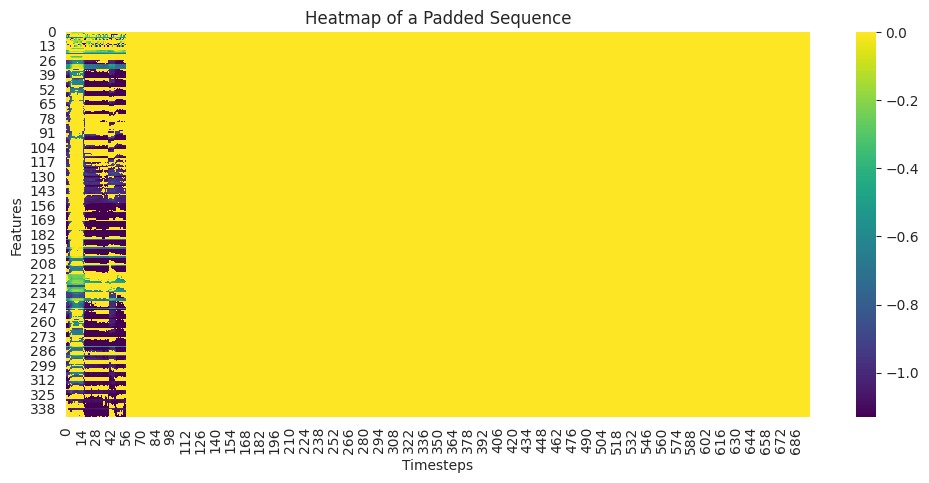

In [26]:
# select a sample to view (the first one)
sample_to_view = train_padded_ALL[0]

# create the heatmap
plt.figure(figsize=(12, 5))
sns.heatmap(sample_to_view.T, cmap='viridis', robust=True)
plt.title('Heatmap of a Padded Sequence')
plt.xlabel('Timesteps')
plt.ylabel('Features')
plt.show()

In its purest form, this is what we are feeding into our model. You can think of it like a blank card or a ticket with a small code. All of the 3D acceleration/orientation information, temperature data, and the five TOF depth maps, are embedded in that tiny code at the very end. The rest is empty padding that our model will quickly learn to ignore. Super cool!

***

## 💽 Training the Neural Network

Now we're getting to the real meat of the project, which is training the neural network. Training a neural network is much more complex than a traditional model and requires a more open-ended and experimental approach. 

Before we get started, we're gonna define a dummy model to use as a baseline to improve upon. This produces an accuracy of about 7-8%, a result that is as good as random guessing.

In [27]:
dummy_clf = DummyClassifier(strategy="most_frequent")

# initialize and fit encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_train_ALL)
y_train = label_encoder.transform(y_train_ALL)
y_val = label_encoder.transform(y_val_ALL)

dummy_clf.fit(train_padded_ALL, y_train_ALL)

# predict on the validation set
y_val_pred_dummy = dummy_clf.predict(val_padded_ALL)

# calculate baseline accuracy
baseline_accuracy = accuracy_score(y_val_ALL, y_val_pred_dummy)
print(f"Baseline (Most Frequent) Accuracy: {baseline_accuracy * 100:.2f}%")

Baseline (Most Frequent) Accuracy: 7.01%


### Note on process: IMU only or all data? 📊

I should take a detour to explain how I approached this stage of the project. My initial plan was to train two different models, one on only the IMU data and one on the entire dataset, and then ensemble the results. This is a pretty common approach that many other submissions took. In a separate notebook, I created a subset of the scaled data containing only the IMU features and did all of my initial model configuration on that dataset. My logic was that it would be easier to experiment with the smaller dataset since it is less complex, and once I got decent performance (say over 50%), I would adapt that configuration for the full dataset.

As you will see however, I did not end up ensembling two models. What ended up happening was that when I brought over the best configuration (55% at the time on the IMU data), it actually scored better, not only overall, but for virtually every gesture. So I came to the conclusion that I would likely not get much value from ensembling and proceeded with just training on the whole dataset.

I mention all of this because the below section documents results from training on **only** the IMU data, not the full dataset. 
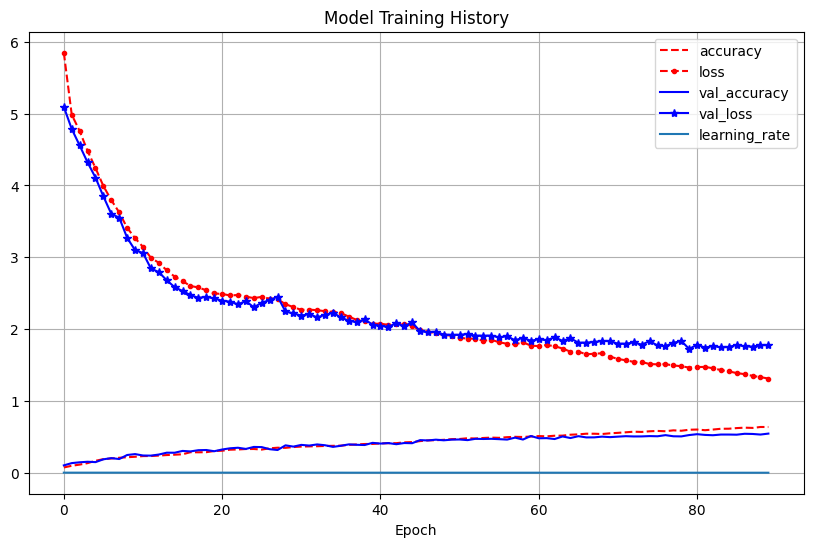

***

## 💿 Model Configuration

**✎  First Iteration:** Shallow CNN w/ Classifier, Masking

The first version of the model was simple, containing a single Conv1D layer (64 filters), RELU, a pooling layer, and a dense layer for classification, with a standard Adam optimizer for the compiler. This initial setup got 10% val accuracy, only slightly better than random guessing. I tried removing the masking layer out of curiousity, and to my surprise the performance actually improved - apparently the CNN is already smart enough to learn to ignore the padding without being explicitly told to do so.

I also experimented a bit with adding LSTM and GRU to this version of the model thinking they might help with sequence recognition, but this led to low performance.

**✎  Second Iteration** Deep CNN, MLP, Batch Normalization, Dropout

Getting nowhere with my baby model I developed the Shallow CNN into a Deep CNN with 5 layers (128, 128, 256, 256, 512 filters respectively) and created replaced the single classifier with a Multi-Layer Perceptron (MLP) containing 3 Dense layers. 

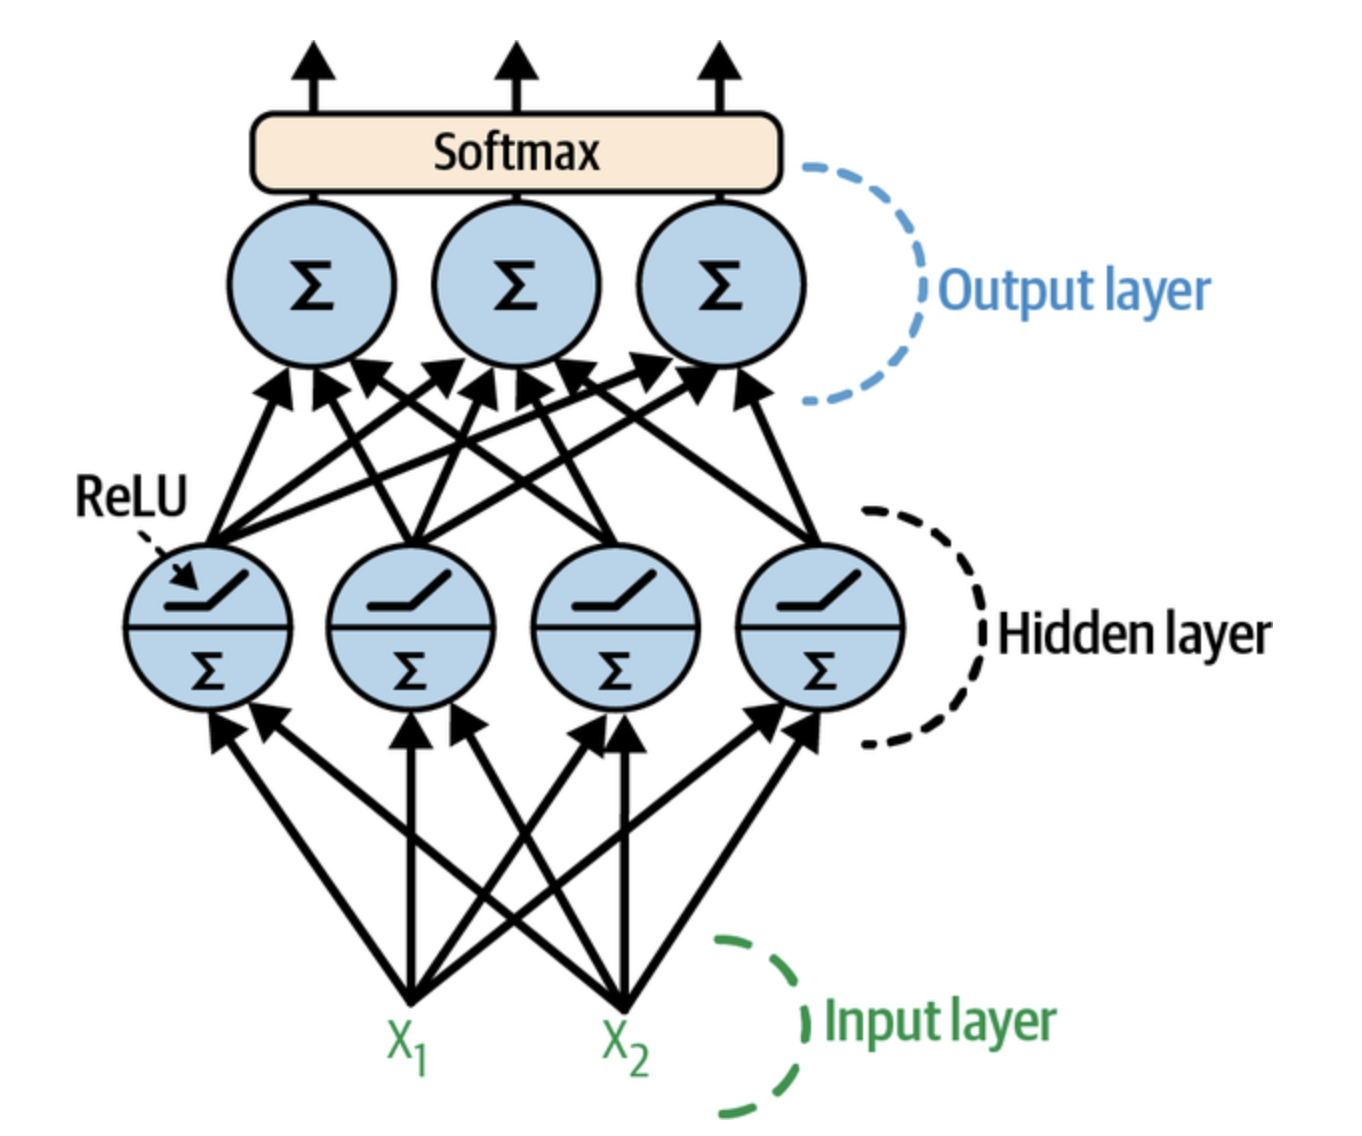

After each Conv1D layer I added a Batch Normalization layer for stabilization and a Dropout layer to reduce overfitting. Dropout periodically kills certain neurons in the network so the model does not become overly dependent on certain neural pathways that may cause the model to overfit the training data.

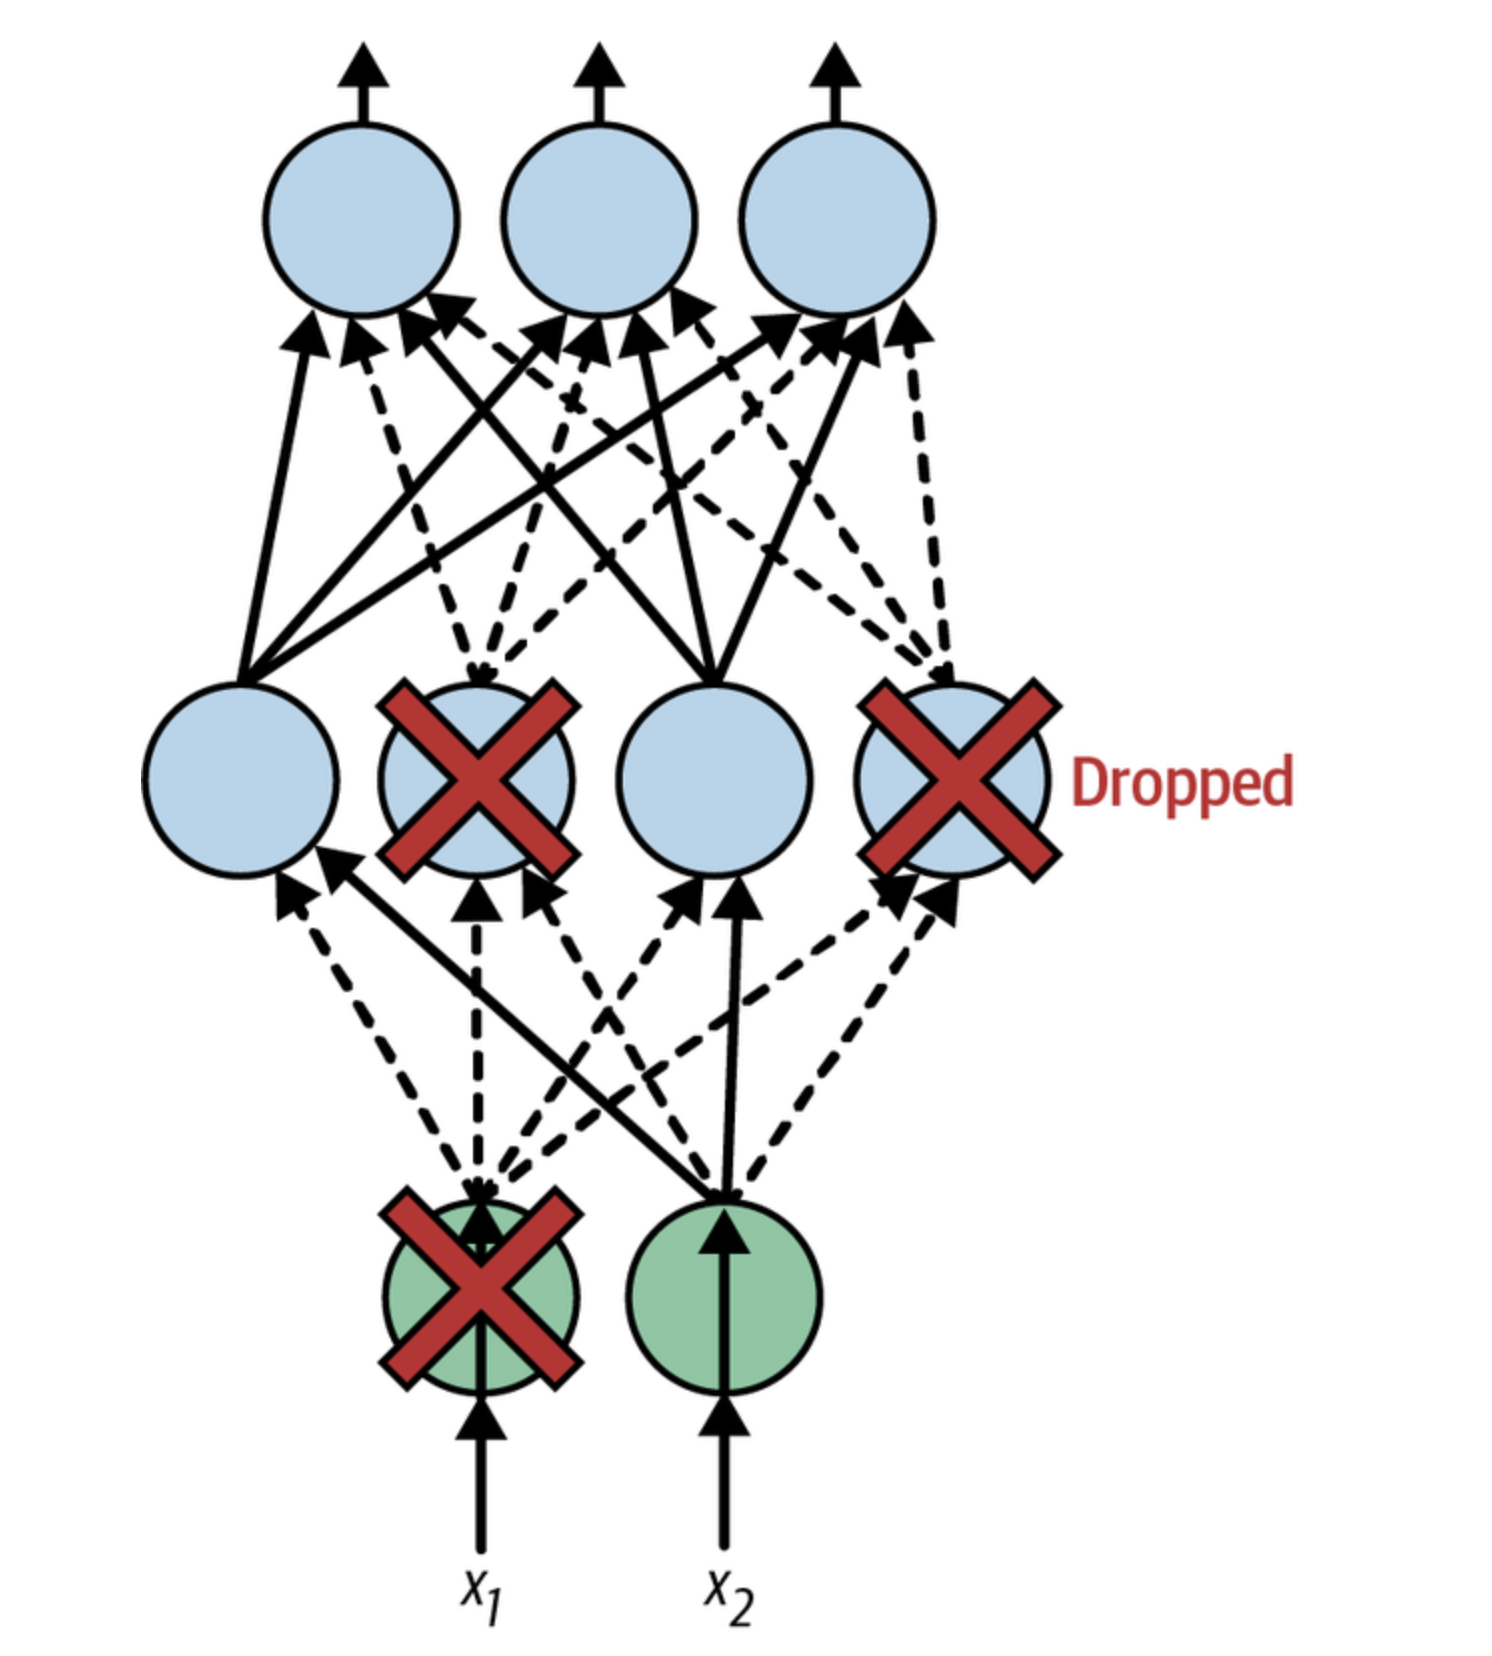

This more robust model architecture bumped the total parameter count from 3,358 to 1,988,370 and boosted the val accuracy to the mid-20% range. I played around with tuning dropout strength further, and found that increasing dropout past 0.3-0.5 was overkill and would prevent the model from retaining any information.

**✎  Third Iteration** AdamW, L2 Regularization

After being stuck for a while it occured to me I had not yet touched the compiler. I decided to experiment with other optimizers like AdamW and RMSprop, and got the biggest boost from AdamW, which bumped the model up to about 35% val accuracy.

It was at this point I discovered a trend - it seemed that the more regularization/punishment I introduced to the model, the more performance improved. To test this out I added L2 regularization to each layer, and sure enough the val accuracy shot up to 48%!

I wanted to see how much further I could take this and experimented with a few different regularization strengths. In the end the best performance came from regularization strength 0.001, as the other configurations were either too lax or too punishing. I also tried some different learning rates for AdamW, like 0.00001, 0.0001, 0.0005, 0.001, and 0.01 - again, the middle options 0.0005 and 0.001 won out.

**✎  Migrating to Main Notebook**

At this point I was sitting at about 55% val accuracy. This is not a perfect score by any means, but my goal from the start was simply to prove to myself that I could build a neural network that was at least correct *most* of the time. Having accomplished my goal I brought the configuration over to the main notebook, and to my surprise and delight got even better performance of 65% val accuracy! 🥳

What you see below is the final model configuration.

In [28]:
# garbage collection (for memory)
del sequences_train_ALL
del sequences_test_ALL
del sequences_val_ALL
del labels_train_ALL
del labels_val_ALL

# set variables
num_timesteps = 700 
num_features = 345
num_classes = 18

# define model
model_ALL = Sequential([
    
    # block 1 
    Input(shape=(num_timesteps, num_features)),
    Conv1D(filters=128, kernel_size=7, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # block 2 
    Conv1D(filters=256, kernel_size=5, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # block 3
    Conv1D(filters=256, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    # block 4
    Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.4),
    
    # block 5
    Conv1D(filters=512, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dropout(0.4),
    
    # dense layers
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

# compile model
model_ALL.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_ALL.summary()

I0000 00:00:1764480652.285359      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1764480652.285888      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 694, 128)       │       309,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 694, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 347, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 347, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 343, 256)       │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 343, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 171, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 171, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 169, 256)       │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 169, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 84, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 82, 512)        │       393,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 82, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 41, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 39, 512)        │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 39, 512)        │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 512)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             

 Total params: 2,286,738 (8.72 MB)

 Trainable params: 2,283,410 (8.71 MB)

 Non-trainable params: 3,328 (13.00 KB)

Throughout the process I also experimented with some of the model training parameters. For the second iteration I added a ReduceLROnPlateau callback to lower the learning rate whenever the model's val loss doesn't improve after 10 epochs, which improved performance. I also experimented with batch sizes 64 and 32, and found slightly better performance with smaller batch sizes.

Labels successfully encoded.
Training model...
Epoch 1/200


I0000 00:00:1764480675.232881     119 service.cc:148] XLA service 0x784e4810a2c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764480675.234180     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764480675.234217     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764480676.067881     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/198 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step - accuracy: 0.0278 - loss: 15.9651

I0000 00:00:1764480685.168814     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


198/198 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.0601 - loss: 7.5650 - val_accuracy: 0.0814 - val_loss: 5.2994 - learning_rate: 0.0010
Epoch 2/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.0748 - loss: 5.2754 - val_accuracy: 0.1067 - val_loss: 5.0334 - learning_rate: 0.0010
Epoch 3/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1022 - loss: 4.9561 - val_accuracy: 0.1319 - val_loss: 4.5423 - learning_rate: 0.0010
Epoch 4/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1295 - loss: 4.5627 - val_accuracy: 0.1667 - val_loss: 4.2792 - learning_rate: 0.0010
Epoch 5/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1553 - loss: 4.2682 - val_accuracy: 0.1894 - val_loss: 4.0305 - learning_rate: 0.0010
Epoch 6/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.1869 - loss: 3.9615 - val_accuracy: 0.2229 - val_loss: 3.6824 - learning_rate: 0.0010
Epoch 7/200
198/198 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.2008 - loss: 3.7257

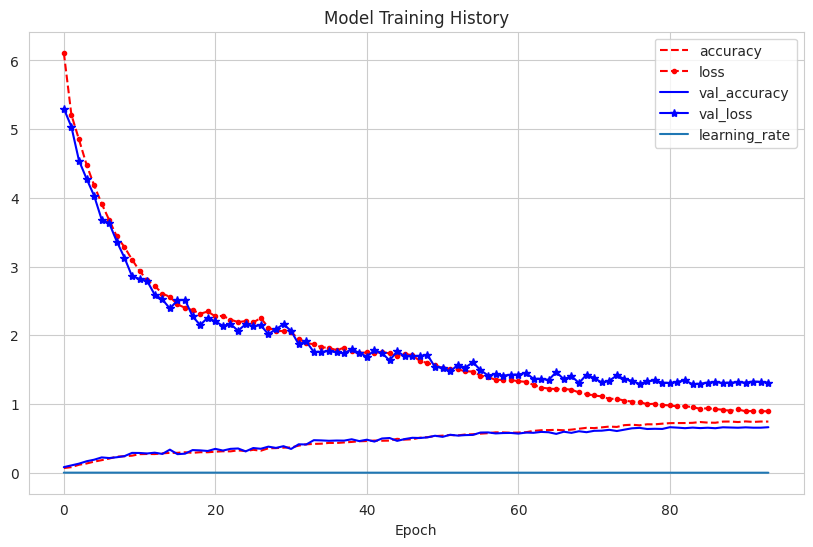

In [29]:
# encode labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train_ALL)
y_train_encoded_ALL = label_encoder.transform(y_train_ALL)
y_val_encoded_ALL = label_encoder.transform(y_val_ALL)
print("Labels successfully encoded.")

# define early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.7, patience=3, min_lr=1e-7, verbose=1)

# train model!!!
print("Training model...")
history_ALL = model_ALL.fit(train_padded_ALL, y_train_encoded_ALL, epochs=200, batch_size=32, validation_data=(val_padded_ALL, y_val_encoded_ALL), callbacks=[early_stopping, reduce_lr])
print("Training complete.")

# plot train/val accuracy/loss
history_ALL_ = pd.DataFrame(history_ALL.history)
history_ALL_.plot(figsize=(10, 6), grid=True, xlabel="Epoch", style=["r--", "r--.", "b-", "b-*"])
plt.title("Model Training History")
plt.show()

We can see from the resulting curves a couple of things about our training process. 
The training and validation accuracy increase quickly from epochs 1-10, then both increase at a steady pace until around epoch 60, when the val accuracy starts to trail behind. This means the model starts overfitting near the end of the training process, which causes the final train accuracy score to end up about 10 points higher than the val accuracy.

Something similar happens with loss, only the losses for train and val diverge at around epoch 40. Val loss plateaus suddenly and in a more pronounced way when compared with val accuracy, while train loss continues to decrease at a steady pace.

Because of the way that val loss plateaus, I wondered what would happen if I instead changed the early stopping callback to be conditioned on val accuracy itself, since val accuracy seems to continue increasing (albeit slowly). However when I tried this, the model struggled to make much progress past epoch 90 and the end result was pretty much the same.
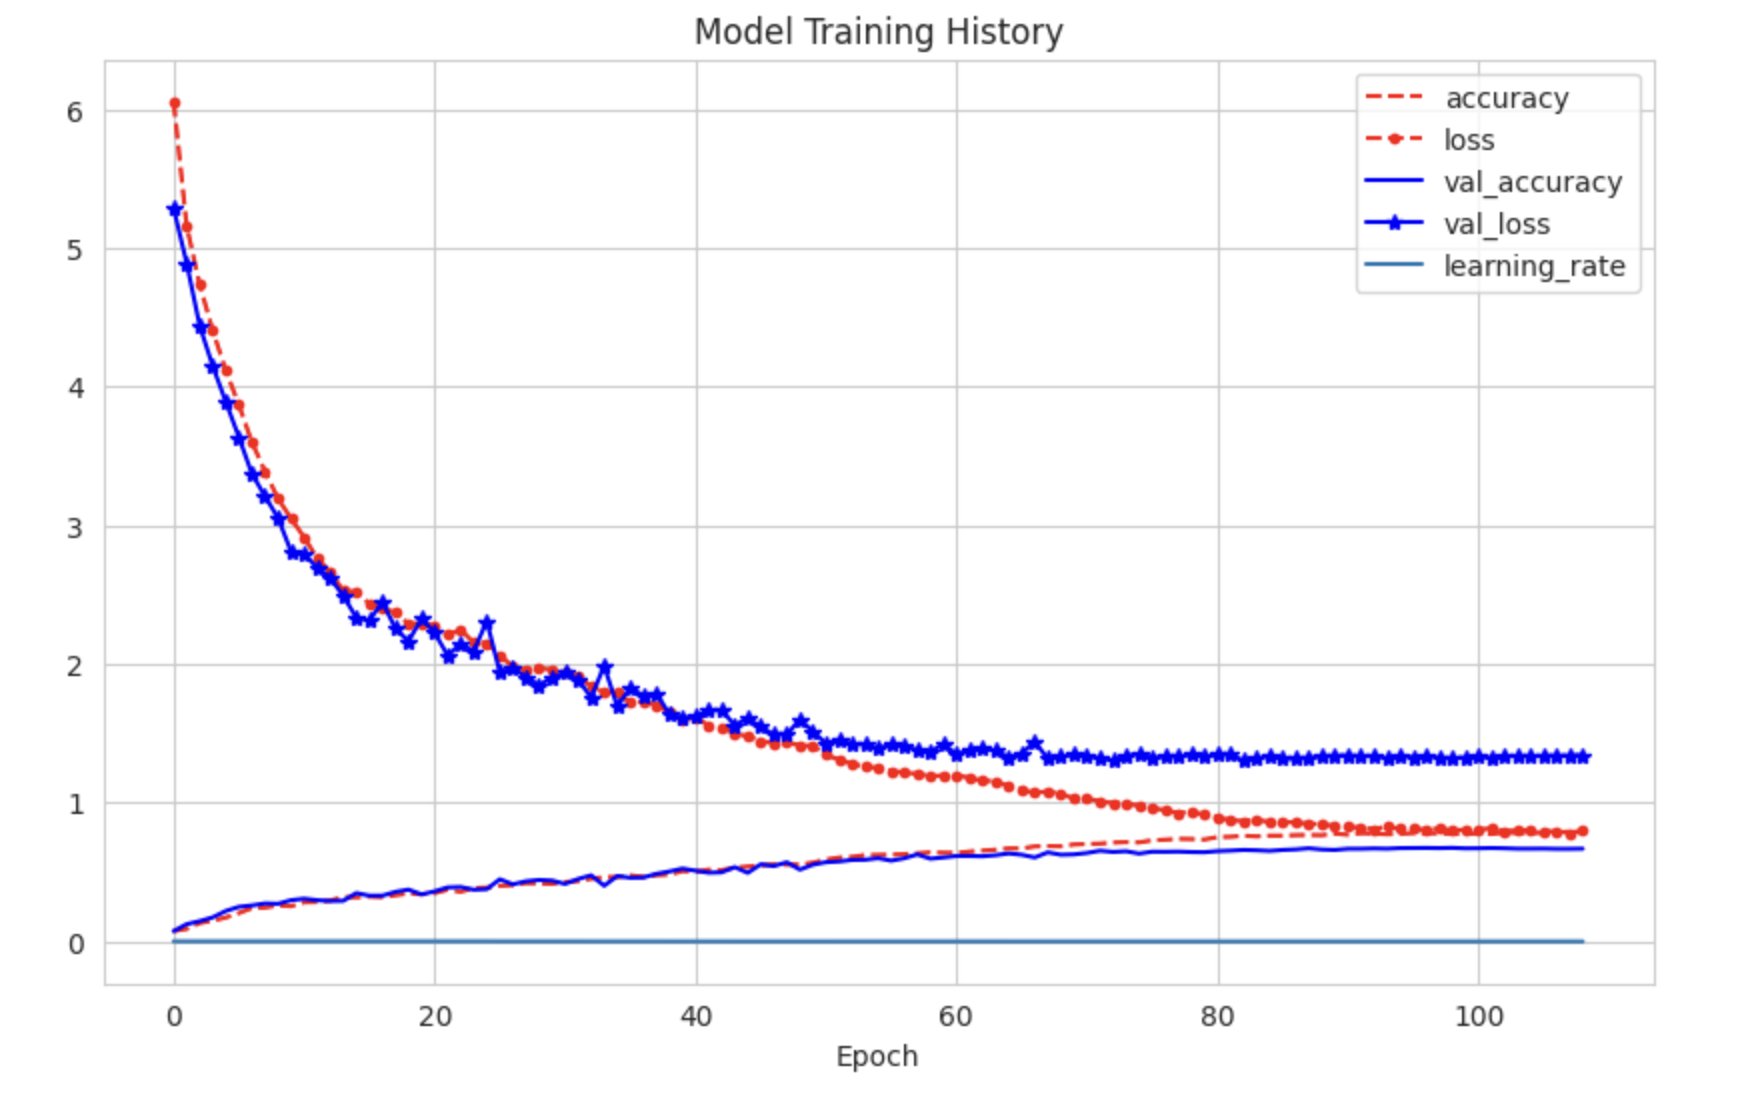

## 🧑‍🏫 Evaluating the Model

Now, it is time to "grade" our model's performance.

In [30]:
# generate predictions
val_probabilities = model_ALL.predict(val_padded_ALL)
y_pred_val_ALL = np.argmax(val_probabilities, axis=1)
print("First 10 Validation Predictions:")
print(y_pred_val_ALL[:10])
print("\nFirst 10 True Validation Labels:")
print(y_val_encoded_ALL[:10])

# generate classification report for IMU-only features
gesture_names_int = label_encoder.classes_
gesture_names_str = [str(name) for name in gesture_names_int]
report = classification_report(y_val_encoded_ALL, y_pred_val_ALL, target_names=gesture_names_str)
print(report)

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step
First 10 Validation Predictions:
[ 4  9  0  5  4 10 12 10  7  1]

First 10 True Validation Labels:
[ 1 10  0  5  3 10 12  9  7  3]
                                            precision    recall  f1-score   support

                     Above ear - pull hair       0.83      0.84      0.83       117
                        Cheek - pinch skin       0.53      0.57      0.55       130
                     Drink from bottle/cup       0.86      1.00      0.93        25
                       Eyebrow - pull hair       0.44      0.40      0.42       123
                       Eyelash - pull hair       0.47      0.63      0.54       111
Feel around in tray and pull out an object       0.94      0.91      0.92        32
                  Forehead - pull hairline       0.66      0.48      0.56       135
                        Forehead - scratch       0.60      0.70      0.65       138
                            Glasses on/off       0.97      0.94      0.9

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**✎  A Quick Breakdown of the Evaluation Metrics**

- *Precision:* the ratio of the true positives to the true positives + false positives

- *Recall:* the ratio of the true positives to the true positives + false negatives

- *F1-score:* the harmonic mean of precision and recall

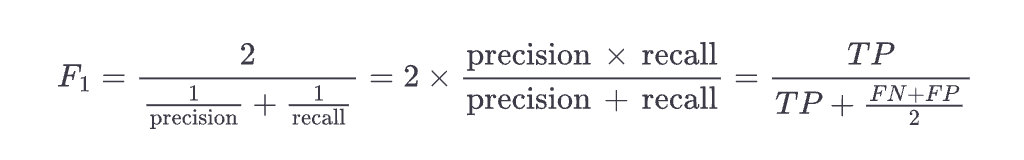

- *Support:* the number of times a gesture appears in the dataset

Even with a decent overall weighted average, some of the model's issues can be identified on closer inspection.

For instance, let us take a look at "Write name on leg". This gesture got a recall of 1.0, meaning every instance of the gesture was predicted correctly, but also a precision of 0.3, meaning that in the process, it also incorrectly guessed lots other sequences to be "Write name on leg".

Now, let us shift our focus to "Pinch knee/leg skin". This gesture has the opposite problem - it has a precision of 1.0 but a recall of 0.03. Given a count of only 34, this implies that it only guessed 1 gesture to be "Pinch knee/leg skin". That one prediction may have been correct, but every other sequence of "Pinch knee/leg skin" was incorrectly classified to be something else! Gee I wonder what... 🤔

Much like human people, the model gets confused sometimes. But overall I am quite happy with this result. 😊

***

## Submitting to Kaggle

The evaluation metric for this contest is a version of macro F1 that equally weights two components:

**✎  Binary F1** on whether the gesture is one of the target or non-target types

**✎  Macro F1** on gesture, where all non-target sequences are collapsed into a single non_target class

The final score is the average of the binary F1 and the macro F1 scores.

In [31]:
LABELS = [
    'Above ear - pull hair',
    'Cheek - pinch skin',
    'Drink from bottle/cup',
    'Eyebrow - pull hair',
    'Eyelash - pull hair',
    'Feel around in tray and pull out an object',
    'Forehead - pull hairline',
    'Forehead - scratch',
    'Glasses on/off',
    'Neck - pinch skin',
    'Neck - scratch',
    'Pinch knee/leg skin',
    'Pull air toward your face',
    'Scratch knee/leg skin',
    'Text on phone',
    'Wave hello',
    'Write name in air',
    'Write name on leg'
]

In [32]:
import polars as pl

def process_single_sequence(df_seq: pd.DataFrame) -> np.ndarray:
    if isinstance(df_seq, pl.DataFrame):
        df_seq = df_seq.to_pandas()
    
    df_seq = df_seq.copy()

    # drop duplicate rows
    df_seq.drop_duplicates(inplace=True)

    # replace -1 and 0 with NaN in TOF columns
    tof_cols = [c for c in df_seq.columns if c.startswith('tof_')]
    if tof_cols:
        df_seq[tof_cols] = df_seq[tof_cols].replace([-1, 0], np.nan)

    # impute missing rot values with 0
    rots = ["rot_w", "rot_x", "rot_y", "rot_z"]
    existing_rots = [c for c in rots if c in df_seq.columns]
    if existing_rots:
        df_seq[existing_rots] = df_seq[existing_rots].fillna(0)

    # fill missing temperature data with average by column (Constant 0 strategy)
    thms = ["thm_1", "thm_2", "thm_3", "thm_4", "thm_5"]
    existing_thms = [c for c in thms if c in df_seq.columns]
    if existing_thms:
        df_seq[existing_thms] = df_seq[existing_thms].fillna(0)

    # fill all NaNs in time-of-flight (ToF) columns with 400
    if tof_cols:
        df_seq[tof_cols] = df_seq[tof_cols].fillna(400)

    # linear interpolation for missing acceleration data
    acc_cols = ["acc_x", "acc_y", "acc_z"]
    if all(c in df_seq.columns for c in acc_cols):
        df_seq[acc_cols] = df_seq[acc_cols].interpolate(method='linear', limit_direction='both')

    # drop unnecessary columns
    columns_to_drop = ['row_id', 'sequence_type', 'sequence_counter', 'subject', 'orientation', 'behavior', 'phase']
    df_seq = df_seq.drop(columns=[col for col in columns_to_drop if col in df_seq.columns])

    # calculate new features and concatenate
    new_features_df = calculate_sequence_features(df_seq)
    df_processed = pd.concat([df_seq, new_features_df], axis=1)
    
    # reorder columns
    NEW_IMU_FEATURES = [
        'lin_acc_x', 'lin_acc_y', 'lin_acc_z',
        'acc_mag', 'lin_acc_mag', 
        'acc_mag_jerk', 'lin_acc_mag_jerk', 
        'rot_angle', 'angular_distance', 'rot_angle_vel', 
        'angular_vel_x', 'angular_vel_y', 'angular_vel_z'
    ]
    
    id_cols = ['sequence_id']
    if 'gesture' in df_processed.columns:
        id_cols.append('gesture')
    
    original_cols = [
        col for col in df_processed.columns 
        if col not in id_cols and col not in NEW_IMU_FEATURES
    ]
    
    final_order = id_cols + NEW_IMU_FEATURES + original_cols
    final_order = [c for c in final_order if c in df_processed.columns]
    df_processed = df_processed[final_order]

    # scale features
    cols_to_exclude = ['sequence_id', 'gesture']
    cols_to_scale = [c for c in df_processed.columns if c not in cols_to_exclude]
    df_processed[cols_to_scale] = scaler.transform(df_processed[cols_to_scale])

    # pad sequence
    if 'sequence_id' in df_processed.columns:
        df_processed = df_processed.drop(columns=['sequence_id'])
    if 'gesture' in df_processed.columns:
        df_processed = df_processed.drop(columns=['gesture'])
    padded_sequences = pad_sequences([df_processed.values], padding='post', dtype='float32', maxlen=700)

    return padded_sequences

In [33]:
# define prediction for hidden test set
def predict(sequence: pd.DataFrame, demographics: pd.DataFrame) -> str:
    input_data = process_single_sequence(sequence)
    prediction_probs = model_ALL.predict(input_data, verbose=0) 
    predicted_index = np.argmax(prediction_probs, axis=1)[0]
    predicted_label = LABELS[predicted_index]
    return predicted_label

In [34]:
import kaggle_evaluation.cmi_inference_server

inference_server = kaggle_evaluation.cmi_inference_server.CMIInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        data_paths=(
            '/kaggle/input/cmi-detect-behavior-with-sensor-data/test.csv',
            '/kaggle/input/cmi-detect-behavior-with-sensor-data/test_demographics.csv',
        )
    )